# Figure 1 & S1

This notebook provides code for reproducing Figures 1 and S1 from Yang\*, Jones\* et al, _bioRxiv_ 2021.

In [1]:
import os
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd 
import seaborn as sns

import cassiopeia.ProcessingPipeline.process.lineageGroup as lg_util
import cassiopeia.TreeSolver.utilities as util

from tqdm import tqdm_notebook

## Process unfiltered allele table & identify consensus intBCs

Here we will demonstrate how to convert allele tables into character matrices, filter out "normal" cells identified from a lack of Cas9 activity, and subset the full set of intBCs to a small "consensus" set observed consistently across tumors from the same clone.

In [ ]:
data_directory = "/path/to/KPTracer-Data/"

In [2]:
allele_table_unfiltered = pd.read_csv(f"{data_directory}/KPTracer.alleleTable.unfiltered.txt", sep='\t', index_col = 0)
trcr_master = pd.read_csv(f"{data_directory}/trcr_master.txt", sep='\t')
meta = pd.read_csv(f"{data_directory}/KPTracer_meta.csv", sep=',', index_col = 0)
tumor_list = pd.read_csv(f"{data_directory}/trees/tumor_list.txt", sep='\t')

/home/eecs/mattjones/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
def compute_perc_indels(cm):

    all_vals = cm.values.ravel()
    num_not_missing = len([n for n in all_vals if n != '-'])
    num_uncut = len([n for n in all_vals if n == '0'])

    return 1.0 - (num_uncut / num_not_missing)

def percent_uncut(x):
    uncut = 0
    for i in x:
        if i == '0':
            uncut += 1
    return uncut / max(1, len([i for i in x if i != '-']))

def drop_exhausted_targets(cm, p = 0.98):
    
    to_drop = []
    for col in cm.columns:
        states = cm[col].values
        uniq_vals = [val for val in states if val != '0' and val != '-']
        total_nonmissing = len([val for val in states if val != '-'])
        
        unique, counts = np.unique(uniq_vals, return_counts=True)
        
        counts = np.array(counts) / total_nonmissing
        
        if np.max(counts) >= p:
            to_drop.append(col)
            
    return to_drop

In [5]:
keep_cellbcs = []
error_tumors = []

for tumor, tumor_at in allele_table_unfiltered.groupby('Tumor'):
    clone = meta.loc[meta['Tumor'] == tumor, 'ES_clone'].iloc[0]

    if type(clone) != str:
        continue

    if 'All' in tumor or 'Met' in tumor or "Fam" in tumor:
        continue

    if 'Normal' in tumor or 'Imm' in tumor:
        continue

    lg = lg_util.collectAlleles(tumor_at, thresh=0.2)[0]
    
    try:
        cm2, priors, state2indel = util.alleletable_to_character_matrix(lg, write=False, mutation_map = None, allele_rep_thresh = 0.98)
    except:
        cm2, priors, state2indel = util.alleletable_to_character_matrix(lg, write=False, mutation_map = None, allele_rep_thresh = 1.0)
        
    pu = cm2.apply(lambda x: percent_uncut(x.values), axis=1)
    
    cmf = cm2[pu < 0.8]
    
    cellbcs = cmf.index.values
    
    meta.loc[pu.index, 'percent_uncut'] = pu.values

    keep_cellbcs += list(cellbcs)

Processing characters: 100%|██████████| 5/5 [00:00<00:00, 1345.10it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACATTATTAGATAC_r2', 'ACATTATTAGATAC_r3', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3', 'TTTTGTGTTTCATC_r2', 'TTTTGTGTTTCATC_r3', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3']



Processing characters: 100%|██████████| 12/12 [00:00<00:00, 3905.61it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACATCTGCGAGATT_r1', 'ACATCTGCGAGATT_r2', 'ACATTATTAGATAC_r1', 'ACATTATTAGATAC_r2', 'ACATTATTAGATAC_r3', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'GATAGCACAAAACG_r3', 'TCTATACTGACGGA_r1', 'TCTATACTGACGGA_r2', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTTTGTGTTTCATC_r2']



100%|██████████| 1/1 [00:00<00:00, 164.70it/s]
Processing characters: 0it [00:00, ?it/s]
Processing characters: 100%|██████████| 32/32 [00:00<00:00, 36531.77it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACATTATTAGATAC_r1', 'ACATTATTAGATAC_r2', 'ACATTATTAGATAC_r3', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3', 'TTTTGTGTTTCATC_r1', 'TTTTGTGTTTCATC_r2', 'TTTTGTGTTTCATC_r3']
Dropping the following intBCs due to lack of diversity with threshold 1.0: []
Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACGTGCAAGGACGC_r3']


Processing characters: 100%|██████████| 39/39 [00:00<00:00, 4752.41it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GATAGCACAAAACG_r3', 'TCAGGCGATGCGAA_r2', 'TCAGGCGATGCGAA_r3', 'TTCCCTATTTGCTA_r1', 'GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TGTGAAGGTCAATA_r3', 'TATGATTAGTCGCG_r1', 'TATGATTAGTCGCG_r2', 'TATGATTAGTCGCG_r3', 'ACTCTGCTCCAGAT_r2', 'ACTCTGCTCCAGAT_r3', 'ACAGGTGCTCAAAT_r1', 'ACAGGTGCTCAAAT_r2', 'ACAGGTGCTCAAAT_r3']



Processing characters: 100%|██████████| 32/32 [00:00<00:00, 9184.19it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACAGGTGCTCAAAT_r1', 'ACAGGTGCTCAAAT_r2', 'ACAGGTGCTCAAAT_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'GTTTATTTCCGTAT_r1', 'GTTTATTTCCGTAT_r2', 'TCAGGCGATGCGAA_r2', 'TCAGGCGATGCGAA_r3', 'GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3', 'TATGATTAGTCGCG_r1', 'TATGATTAGTCGCG_r2', 'TATGATTAGTCGCG_r3', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TGTGAAGGTCAATA_r3', 'TTCCCTATTTGCTA_r1']



Processing characters: 100%|██████████| 27/27 [00:00<00:00, 38427.62it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GTTTATTTCCGTAT_r1', 'GTTTATTTCCGTAT_r2', 'TATGCCGCCAGTTT_r2', 'TTTTGTGTTTCATC_r2', 'TTTTGTGTTTCATC_r3', 'GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TGTGAAGGTCAATA_r3', 'TCAGGCGATGCGAA_r2', 'TCAGGCGATGCGAA_r3', 'TTCCCTATTTGCTA_r1', 'TTCCCTATTTGCTA_r2']


Processing characters: 100%|██████████| 21/21 [00:00<00:00, 6234.46it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACATCTGCGAGATT_r1', 'ACATCTGCGAGATT_r2', 'GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3', 'TATGCCGCCAGTTT_r1', 'TATGCCGCCAGTTT_r2', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TGTGAAGGTCAATA_r3', 'TTACATGCTACCCC_r2', 'TTTTGTGTTTCATC_r1', 'TTTTGTGTTTCATC_r2', 'GTTTATTTCCGTAT_r1', 'GTTTATTTCCGTAT_r2', 'TCAGGCGATGCGAA_r2', 'TCAGGCGATGCGAA_r3', 'TCTATACTGACGGA_r2', 'TATGATTAGTCGCG_r1', 'TATGATTAGTCGCG_r2', 'TATGATTAGTCGCG_r3', 'TTCCCTATTTGCTA_r1', 'ACTCTGCTCCAGAT_r2', 'ACTCTGCTCCAGAT_r3', 'ACAGGTGCTCAAAT_r1', 'ACAGGTGCTCAAAT_r2', 'ACAGGTGCTCAAAT_r3']



Processing characters: 100%|██████████| 5/5 [00:00<00:00, 864.84it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACATCTGCGAGATT_r1', 'ACATCTGCGAGATT_r2', 'ACATCTGCGAGATT_r3', 'ACATTATTAGATAC_r1', 'ACATTATTAGATAC_r2', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'GTGCAAGCCTTATC_r1', 'GTGCAAGCCTTATC_r2', 'TATGCCGCCAGTTT_r1', 'TATGCCGCCAGTTT_r2', 'TATGCCGCCAGTTT_r3', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3']



Processing characters: 100%|██████████| 33/33 [00:00<00:00, 1496.75it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: []



Processing characters: 100%|██████████| 9/9 [00:00<00:00, 737.44it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACATTATTAGATAC_r1', 'ACATTATTAGATAC_r2', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'TTTTGTGTTTCATC_r2', 'TCTATACTGACGGA_r1']



Processing characters: 100%|██████████| 33/33 [00:00<00:00, 1594.11it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: []



Processing characters: 100%|██████████| 33/33 [00:00<00:00, 6286.31it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: []



Processing characters: 100%|██████████| 33/33 [00:00<00:00, 6166.99it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: []



Processing characters: 100%|██████████| 23/23 [00:00<00:00, 11650.84it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTGAAACAGGTTTA_r1', 'CTGAAACAGGTTTA_r2', 'GTGCAAGCCTTATC_r3', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTTTGTGTTTCATC_r1']


Processing characters: 100%|██████████| 4/4 [00:00<00:00, 1571.05it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACATTATTAGATAC_r1', 'ACATTATTAGATAC_r2', 'ACATTATTAGATAC_r3', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'TCTATACTGACGGA_r1', 'TCTATACTGACGGA_r2', 'TCTATACTGACGGA_r3', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3', 'TTTTGTGTTTCATC_r1', 'TTTTGTGTTTCATC_r2', 'TTTTGTGTTTCATC_r3']



100%|██████████| 1/1 [00:00<00:00, 145.73it/s]
Processing characters: 0it [00:00, ?it/s]
Processing characters: 100%|██████████| 21/21 [00:00<00:00, 13060.56it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACATCTGCGAGATT_r1', 'ACATCTGCGAGATT_r2', 'ACATCTGCGAGATT_r3', 'ACATTATTAGATAC_r1', 'ACATTATTAGATAC_r2', 'ACATTATTAGATAC_r3', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'TCTATACTGACGGA_r1', 'TCTATACTGACGGA_r2', 'TCTATACTGACGGA_r3', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3', 'TTTTGTGTTTCATC_r1', 'TTTTGTGTTTCATC_r2', 'TTTTGTGTTTCATC_r3']
Dropping the following intBCs due to lack of diversity with threshold 1.0: []


  0%|          | 0/1 [00:00<?, ?it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: []
Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACATCTGCGAGATT_r1', 'ACATCTGCGAGATT_r2', 'ACATTATTAGATAC_r1', 'ACATTATTAGATAC_r2', 'ACATTATTAGATAC_r3', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'TCTATACTGACGGA_r1', 'TCTATACTGACGGA_r2', 'TCTATACTGACGGA_r3', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3', 'TTTTGTGTTTCATC_r1', 'TTTTGTGTTTCATC_r2', 'TTTTGTGTTTCATC_r3']


Processing characters: 100%|██████████| 21/21 [00:00<00:00, 2824.27it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: []



100%|██████████| 1/1 [00:00<00:00, 154.26it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACATCTGCGAGATT_r2', 'ACATTATTAGATAC_r1', 'ACATTATTAGATAC_r2', 'ACATTATTAGATAC_r3', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3', 'TTTTGTGTTTCATC_r1', 'TTTTGTGTTTCATC_r2', 'TTTTGTGTTTCATC_r3', 'TCTATACTGACGGA_r1', 'TCTATACTGACGGA_r2', 'TCTATACTGACGGA_r3']


Processing characters: 100%|██████████| 21/21 [00:00<00:00, 8381.42it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: []


Processing characters: 100%|██████████| 21/21 [00:00<00:00, 33338.53it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: []


Processing characters: 100%|██████████| 13/13 [00:00<00:00, 21628.70it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TCTATACTGACGGA_r2', 'TCTATACTGACGGA_r3']


100%|██████████| 1/1 [00:00<00:00, 180.91it/s]
Processing characters: 0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00, 85.17it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACATCTGCGAGATT_r1', 'ACATCTGCGAGATT_r2', 'ACATCTGCGAGATT_r3', 'ACATTATTAGATAC_r1', 'ACATTATTAGATAC_r2', 'ACATTATTAGATAC_r3', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'GTGCAAGCCTTATC_r1', 'GTGCAAGCCTTATC_r2', 'GTGCAAGCCTTATC_r3', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3']
Dropping the following intBCs due to lack of diversity with threshold 1.0: []


Processing characters: 100%|██████████| 4/4 [00:00<00:00, 2020.38it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACATCTGCGAGATT_r1', 'ACATCTGCGAGATT_r2', 'ACATTATTAGATAC_r1', 'ACATTATTAGATAC_r2', 'ACATTATTAGATAC_r3', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'GTGCAAGCCTTATC_r1', 'GTGCAAGCCTTATC_r2', 'TCTATACTGACGGA_r1', 'TCTATACTGACGGA_r2', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2']



Processing characters: 100%|██████████| 20/20 [00:00<00:00, 3463.65it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GTGCAAGCCTTATC_r2']



100%|██████████| 1/1 [00:00<00:00, 107.28it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACGTGCAAGGACGC_r1', 'GTGCAAGCCTTATC_r2']


Processing characters: 100%|██████████| 21/21 [00:00<00:00, 1743.41it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: []



Processing characters: 100%|██████████| 8/8 [00:00<00:00, 10446.59it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACATTATTAGATAC_r2', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'TTACATGCTACCCC_r2']


Processing characters: 100%|██████████| 8/8 [00:00<00:00, 3076.98it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACATCTGCGAGATT_r1', 'ACATCTGCGAGATT_r2', 'ACATTATTAGATAC_r1', 'ACATTATTAGATAC_r2', 'ACATTATTAGATAC_r3', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'GTGCAAGCCTTATC_r2', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3']



100%|██████████| 1/1 [00:00<00:00, 117.88it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACATCTGCGAGATT_r1', 'ACATCTGCGAGATT_r2', 'ACATCTGCGAGATT_r3', 'ACATTATTAGATAC_r1', 'ACATTATTAGATAC_r2', 'ACATTATTAGATAC_r3', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'GTGCAAGCCTTATC_r2', 'GTGCAAGCCTTATC_r3', 'TATGCCGCCAGTTT_r1', 'TATGCCGCCAGTTT_r2', 'TATGCCGCCAGTTT_r3', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3', 'GATAGCACAAAACG_r1', 'GATAGCACAAAACG_r2', 'GATAGCACAAAACG_r3']



100%|██████████| 1/1 [00:00<00:00, 122.35it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACATCTGCGAGATT_r1', 'ACATCTGCGAGATT_r2', 'ACATCTGCGAGATT_r3', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'GTGCAAGCCTTATC_r2', 'GTGCAAGCCTTATC_r3', 'TCTATACTGACGGA_r2', 'TCTATACTGACGGA_r3', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3', 'GATAGCACAAAACG_r1', 'GATAGCACAAAACG_r2', 'GATAGCACAAAACG_r3', 'TTTTGTGTTTCATC_r1', 'TTTTGTGTTTCATC_r2', 'TTTTGTGTTTCATC_r3']
Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACATCTGCGAGATT_r1', 'ACATCTGCGAGATT_r2', 'ACATCTGCGAGATT_r3', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'GTGCAAGCCTTATC_r1', 'GTGCAAGCCTTATC_r2', 'GTGCAAGCCTTATC_r3', 'TCTATACTGACGGA_r2', 'TCTATACTGACGGA_r3', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3', 'TTTTGTGTTTCATC_r1', 'TTTTG


100%|██████████| 1/1 [00:00<00:00, 78.59it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACATCTGCGAGATT_r1', 'ACATCTGCGAGATT_r2', 'ACATCTGCGAGATT_r3', 'ACATTATTAGATAC_r2', 'ACATTATTAGATAC_r3', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'GATAGCACAAAACG_r1', 'GATAGCACAAAACG_r2', 'GATAGCACAAAACG_r3', 'GTGCAAGCCTTATC_r1', 'GTGCAAGCCTTATC_r2', 'GTGCAAGCCTTATC_r3', 'TATGCCGCCAGTTT_r1', 'TATGCCGCCAGTTT_r2', 'TATGCCGCCAGTTT_r3', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3']


Processing characters: 100%|██████████| 27/27 [00:00<00:00, 2723.31it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TGTGAAGGTCAATA_r3', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'GTTTATTTCCGTAT_r1', 'GTTTATTTCCGTAT_r2', 'TATGATTAGTCGCG_r1', 'TATGATTAGTCGCG_r2', 'TATGATTAGTCGCG_r3', 'TCAGGCGATGCGAA_r2', 'TCAGGCGATGCGAA_r3']



Processing characters: 100%|██████████| 25/25 [00:00<00:00, 6198.36it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TGTGAAGGTCAATA_r3', 'GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3', 'TATGATTAGTCGCG_r1', 'TATGATTAGTCGCG_r2', 'TATGATTAGTCGCG_r3', 'TCAGGCGATGCGAA_r2', 'TCAGGCGATGCGAA_r3', 'TTCCCTATTTGCTA_r1', 'GTTTATTTCCGTAT_r1', 'GTTTATTTCCGTAT_r2', 'ACAGGTGCTCAAAT_r1', 'ACAGGTGCTCAAAT_r2', 'ACAGGTGCTCAAAT_r3']



Processing characters: 100%|██████████| 15/15 [00:00<00:00, 5185.41it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'TATGCCGCCAGTTT_r1', 'TATGCCGCCAGTTT_r2', 'TTACATGCTACCCC_r3', 'GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3', 'ACAGGTGCTCAAAT_r1', 'ACAGGTGCTCAAAT_r2', 'ACAGGTGCTCAAAT_r3', 'TATGATTAGTCGCG_r1', 'TATGATTAGTCGCG_r2', 'TATGATTAGTCGCG_r3', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TGTGAAGGTCAATA_r3', 'TCAGGCGATGCGAA_r2', 'TCAGGCGATGCGAA_r3', 'GTTTATTTCCGTAT_r1', 'GTTTATTTCCGTAT_r2']



Processing characters: 100%|██████████| 15/15 [00:00<00:00, 6550.87it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACATCTGCGAGATT_r1', 'ACATCTGCGAGATT_r2', 'ACATCTGCGAGATT_r3', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'CTCTTTTCAGTTCA_r2', 'GTGCAAGCCTTATC_r2', 'TCTATACTGACGGA_r2', 'TCTATACTGACGGA_r3', 'TTACATGCTACCCC_r2', 'TTTTGTGTTTCATC_r2', 'TTTTGTGTTTCATC_r3', 'GATAGCACAAAACG_r1', 'GATAGCACAAAACG_r2']



Processing characters: 100%|██████████| 26/26 [00:00<00:00, 9581.93it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3', 'GTTTATTTCCGTAT_r1', 'GTTTATTTCCGTAT_r2', 'TATGATTAGTCGCG_r1', 'TATGATTAGTCGCG_r2', 'TATGATTAGTCGCG_r3', 'TCAGGCGATGCGAA_r2', 'TCAGGCGATGCGAA_r3', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TGTGAAGGTCAATA_r3']


Processing characters: 100%|██████████| 18/18 [00:00<00:00, 4273.60it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: []



Processing characters: 100%|██████████| 31/31 [00:00<00:00, 8374.56it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CTCTTTTAAGTTCA_r1', 'CTCTTTTAAGTTCA_r3']



Processing characters: 100%|██████████| 10/10 [00:00<00:00, 2937.60it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACATCTGCGAGATT_r1', 'ACATTATTAGATAC_r1', 'ACATTATTAGATAC_r2', 'ACATTATTAGATAC_r3', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'GTGCAAGCCTTATC_r2', 'GTGCAAGCCTTATC_r3', 'TATGCCGCCAGTTT_r1', 'TATGCCGCCAGTTT_r2', 'TATGCCGCCAGTTT_r3', 'TCTATACTGACGGA_r2', 'TCTATACTGACGGA_r3']



Processing characters: 100%|██████████| 27/27 [00:00<00:00, 38284.72it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACATCTGCGAGATT_r1', 'ACATTATTAGATAC_r1', 'ACATTATTAGATAC_r2', 'ACATTATTAGATAC_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'GTGCAAGCCTTATC_r2', 'GTGCAAGCCTTATC_r3', 'TATGCCGCCAGTTT_r1', 'TATGCCGCCAGTTT_r2', 'TATGCCGCCAGTTT_r3', 'TTACATGCTACCCC_r2', 'TTTTGTGTTTCATC_r1', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'TCTATACTGACGGA_r1', 'TCTATACTGACGGA_r2', 'TCTATACTGACGGA_r3']
Dropping the following intBCs due to lack of diversity with threshold 0.98: []


100%|██████████| 1/1 [00:00<00:00, 143.62it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACATCTGCGAGATT_r1', 'ACATCTGCGAGATT_r2', 'ACATTATTAGATAC_r1', 'ACATTATTAGATAC_r2', 'ACATTATTAGATAC_r3', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'GTGCAAGCCTTATC_r1', 'GTGCAAGCCTTATC_r2', 'GTGCAAGCCTTATC_r3', 'TATGCCGCCAGTTT_r1', 'TATGCCGCCAGTTT_r2', 'TATGCCGCCAGTTT_r3', 'TCTATACTGACGGA_r1', 'TCTATACTGACGGA_r2', 'TCTATACTGACGGA_r3', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTTTGTGTTTCATC_r1', 'TTTTGTGTTTCATC_r2']
Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACATCTGCGAGATT_r1', 'ACATCTGCGAGATT_r2', 'ACATTATTAGATAC_r1', 'ACATTATTAGATAC_r2', 'ACATTATTAGATAC_r3', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'GTGCAAGCCTTATC_r2', 'GTGCAAGCCTTATC_r3', 'TTACATGCTACCCC_r2', 'TTTTGTGTTTCATC_r1', 'TATGCCGCCAGTTT_r1', 'TATGC

Processing characters: 100%|██████████| 7/7 [00:00<00:00, 10766.46it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACATCTGCGAGATT_r1', 'ACATTATTAGATAC_r1', 'ACATTATTAGATAC_r2', 'ACATTATTAGATAC_r3', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'GTGCAAGCCTTATC_r2', 'GTGCAAGCCTTATC_r3', 'TATGCCGCCAGTTT_r1', 'TATGCCGCCAGTTT_r2', 'TATGCCGCCAGTTT_r3', 'TCTATACTGACGGA_r1', 'TCTATACTGACGGA_r2', 'TCTATACTGACGGA_r3', 'TTACATGCTACCCC_r2', 'TTTTGTGTTTCATC_r1']


Processing characters: 100%|██████████| 27/27 [00:00<00:00, 3286.21it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: []



100%|██████████| 1/1 [00:00<00:00, 152.42it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACATCTGCGAGATT_r2', 'ACATCTGCGAGATT_r3', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'GTGCAAGCCTTATC_r1', 'GTGCAAGCCTTATC_r2', 'TATGCCGCCAGTTT_r1', 'TATGCCGCCAGTTT_r2', 'TCTATACTGACGGA_r2', 'TCTATACTGACGGA_r3', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3', 'TTTTGTGTTTCATC_r1', 'TTTTGTGTTTCATC_r2']



Processing characters: 100%|██████████| 12/12 [00:00<00:00, 13015.68it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: []


100%|██████████| 1/1 [00:00<00:00, 141.03it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACATCTGCGAGATT_r1', 'ACATCTGCGAGATT_r2', 'ACATCTGCGAGATT_r3', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'GTGCAAGCCTTATC_r1', 'GTGCAAGCCTTATC_r2', 'GTGCAAGCCTTATC_r3', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3', 'TTTTGTGTTTCATC_r2', 'TTTTGTGTTTCATC_r3']


Processing characters: 100%|██████████| 21/21 [00:00<00:00, 4837.46it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: []



Processing characters: 100%|██████████| 21/21 [00:00<00:00, 6605.70it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: []



100%|██████████| 1/1 [00:00<00:00, 142.00it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GATAGCACAAAACG_r1', 'GATAGCACAAAACG_r2', 'GATAGCACAAAACG_r3']


Processing characters: 100%|██████████| 19/19 [00:00<00:00, 7000.95it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GATAGCACAAAACG_r1', 'GATAGCACAAAACG_r2']


100%|██████████| 1/1 [00:00<00:00, 167.56it/s]
Processing characters: 0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00, 136.49it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GATAGCACAAAACG_r3', 'GTGCAAGCCTTATC_r1', 'GTGCAAGCCTTATC_r2', 'GTGCAAGCCTTATC_r3']
Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACATCTGCGAGATT_r1', 'ACATCTGCGAGATT_r2', 'ACATCTGCGAGATT_r3', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'GATAGCACAAAACG_r1', 'GATAGCACAAAACG_r2', 'GATAGCACAAAACG_r3', 'GTGCAAGCCTTATC_r1', 'GTGCAAGCCTTATC_r2', 'GTGCAAGCCTTATC_r3', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3', 'TTTTGTGTTTCATC_r1', 'TTTTGTGTTTCATC_r2', 'TTTTGTGTTTCATC_r3']
Dropping the following intBCs due to lack of diversity with threshold 1.0: []


100%|██████████| 1/1 [00:00<00:00, 145.23it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACATCTGCGAGATT_r1', 'ACATCTGCGAGATT_r2', 'ACATCTGCGAGATT_r3', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'GATAGCACAAAACG_r1', 'GATAGCACAAAACG_r2', 'GATAGCACAAAACG_r3', 'GTGCAAGCCTTATC_r1', 'GTGCAAGCCTTATC_r2', 'GTGCAAGCCTTATC_r3', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3', 'TTTTGTGTTTCATC_r2', 'TTTTGTGTTTCATC_r3']



Processing characters: 100%|██████████| 21/21 [00:00<00:00, 8891.62it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: []


Processing characters: 100%|██████████| 21/21 [00:00<00:00, 15209.87it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: []


Processing characters: 100%|██████████| 19/19 [00:00<00:00, 27546.41it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2']


Processing characters: 100%|██████████| 21/21 [00:00<00:00, 6051.14it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: []



Processing characters: 100%|██████████| 19/19 [00:00<00:00, 6411.76it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3']


Processing characters: 100%|██████████| 24/24 [00:00<00:00, 12085.88it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: []


100%|██████████| 1/1 [00:00<00:00, 174.46it/s]
Processing characters: 0it [00:00, ?it/s]
  0%|          | 0/1 [00:00<?, ?it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: []
Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACATTATTAGATAC_r1', 'ACATTATTAGATAC_r2', 'ACATTATTAGATAC_r3', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'TATGCCGCCAGTTT_r1', 'TATGCCGCCAGTTT_r2', 'TATGCCGCCAGTTT_r3', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3', 'TTTTGTGTTTCATC_r1', 'TTTTGTGTTTCATC_r2', 'TTTTGTGTTTCATC_r3']
Dropping the following intBCs due to lack of diversity with threshold 1.0: []


Processing characters: 100%|██████████| 24/24 [00:00<00:00, 15534.46it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: []


Processing characters: 100%|██████████| 24/24 [00:00<00:00, 15410.79it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: []


Processing characters: 100%|██████████| 21/21 [00:00<00:00, 2995.52it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: []



Processing characters: 100%|██████████| 26/26 [00:00<00:00, 48489.06it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TAACCAAGCCTACA_r2']


Processing characters: 100%|██████████| 35/35 [00:00<00:00, 14672.73it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TAACCAAGCCTACA_r2']


Processing characters: 100%|██████████| 23/23 [00:00<00:00, 13031.07it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ATGATTTAACTACT_r1', 'ATGATTTAACTACT_r3', 'CGATTGGTCACTTA_r1', 'CGATTGGTCACTTA_r2', 'CGATTGGTCACTTA_r3', 'GAACCCACAATTCC_r2', 'GAACCCACAATTCC_r3']


Processing characters: 100%|██████████| 31/31 [00:00<00:00, 9184.39it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ATGATTTAACTACT_r1', 'TAACCAAGCCTACA_r2', 'TCAGGCGATGCGAA_r2', 'TCAGGCGATGCGAA_r3', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TGTGAAGGTCAATA_r3', 'TATGATTAGTCGCG_r1', 'TATGATTAGTCGCG_r2', 'TATGATTAGTCGCG_r3', 'GTTTATTTCCGTAT_r1', 'GTTTATTTCCGTAT_r2', 'TTCCCTATTTGCTA_r1', 'TTCCCTATTTGCTA_r2', 'GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3', 'ACAGGTGCTCAAAT_r1', 'ACAGGTGCTCAAAT_r2', 'ACAGGTGCTCAAAT_r3']



Processing characters: 100%|██████████| 46/46 [00:00<00:00, 11064.86it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GTTTATTTCCGTAT_r2', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TGTGAAGGTCAATA_r3', 'ACAGGTGCTCAAAT_r1', 'ACAGGTGCTCAAAT_r2', 'ACAGGTGCTCAAAT_r3', 'GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3', 'TCAGGCGATGCGAA_r2', 'TCAGGCGATGCGAA_r3', 'CGATTGGTCACTTA_r1', 'TATGATTAGTCGCG_r1', 'TATGATTAGTCGCG_r2', 'TATGATTAGTCGCG_r3', 'TTCCCTATTTGCTA_r1']



Processing characters: 100%|██████████| 5/5 [00:00<00:00, 2491.27it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACAGGTGCTCAAAT_r1', 'ACAGGTGCTCAAAT_r2', 'ACAGGTGCTCAAAT_r3', 'ACTCTGCTCCAGAT_r2', 'ACTCTGCTCCAGAT_r3', 'ATAGGTATGTCGTG_r2', 'ATAGGTATGTCGTG_r3', 'GACTTTATCGATCT_r1', 'GACTTTATCGATCT_r2', 'GACTTTATCGATCT_r3', 'GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3', 'GTTTATTTCCGTAT_r1', 'GTTTATTTCCGTAT_r2', 'TATGATTAGTCGCG_r1', 'TATGATTAGTCGCG_r2', 'TATGATTAGTCGCG_r3', 'TCAGGCGATGCGAA_r2', 'TCAGGCGATGCGAA_r3', 'TGATATAAATCTTT_r1', 'TGATATAAATCTTT_r2', 'TGATATAAATCTTT_r3', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TGTGAAGGTCAATA_r3', 'TTCCCTATTTGCTA_r1', 'TTCCCTATTTGCTA_r2']



Processing characters: 100%|██████████| 6/6 [00:00<00:00, 8104.94it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACAGGTGCTCAAAT_r1', 'ACAGGTGCTCAAAT_r2', 'ACAGGTGCTCAAAT_r3', 'ACTCTGCTCCAGAT_r2', 'ACTCTGCTCCAGAT_r3', 'ATAGGTATGTCGTG_r2', 'ATAGGTATGTCGTG_r3', 'GACTTTATCGATCT_r1', 'GACTTTATCGATCT_r2', 'GACTTTATCGATCT_r3', 'GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3', 'GTTTATTTCCGTAT_r1', 'GTTTATTTCCGTAT_r2', 'TATGATTAGTCGCG_r1', 'TATGATTAGTCGCG_r2', 'TATGATTAGTCGCG_r3', 'TCAGGCGATGCGAA_r2', 'TCAGGCGATGCGAA_r3', 'TGATATAAATCTTT_r1', 'TGATATAAATCTTT_r2', 'TGATATAAATCTTT_r3', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TGTGAAGGTCAATA_r3', 'TTCCCTATTTGCTA_r1']



Processing characters: 100%|██████████| 5/5 [00:00<00:00, 2779.89it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACAGGTGCTCAAAT_r1', 'ACAGGTGCTCAAAT_r2', 'ACAGGTGCTCAAAT_r3', 'ACTCTGCTCCAGAT_r2', 'ACTCTGCTCCAGAT_r3', 'ATAGGTATGTCGTG_r2', 'ATAGGTATGTCGTG_r3', 'GACTTTATCGATCT_r1', 'GACTTTATCGATCT_r2', 'GACTTTATCGATCT_r3', 'GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3', 'GTTTATTTCCGTAT_r1', 'GTTTATTTCCGTAT_r2', 'TATGATTAGTCGCG_r1', 'TATGATTAGTCGCG_r2', 'TATGATTAGTCGCG_r3', 'TCAGGCGATGCGAA_r2', 'TCAGGCGATGCGAA_r3', 'TGATATAAATCTTT_r1', 'TGATATAAATCTTT_r2', 'TGATATAAATCTTT_r3', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TGTGAAGGTCAATA_r3', 'TTCCCTATTTGCTA_r1', 'TTCCCTATTTGCTA_r2']



Processing characters: 100%|██████████| 6/6 [00:00<00:00, 1779.76it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACAGGTGCTCAAAT_r1', 'ACAGGTGCTCAAAT_r2', 'ACAGGTGCTCAAAT_r3', 'ACTCTGCTCCAGAT_r2', 'ACTCTGCTCCAGAT_r3', 'ATAGGTATGTCGTG_r2', 'ATAGGTATGTCGTG_r3', 'GACTTTATCGATCT_r1', 'GACTTTATCGATCT_r2', 'GACTTTATCGATCT_r3', 'GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3', 'GTTTATTTCCGTAT_r1', 'GTTTATTTCCGTAT_r2', 'TATGATTAGTCGCG_r1', 'TATGATTAGTCGCG_r2', 'TATGATTAGTCGCG_r3', 'TCAGGCGATGCGAA_r2', 'TCAGGCGATGCGAA_r3', 'TGATATAAATCTTT_r1', 'TGATATAAATCTTT_r2', 'TGATATAAATCTTT_r3', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TGTGAAGGTCAATA_r3', 'TTCCCTATTTGCTA_r1']



Processing characters: 100%|██████████| 5/5 [00:00<00:00, 2671.87it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACAGGTGCTCAAAT_r1', 'ACAGGTGCTCAAAT_r2', 'ACAGGTGCTCAAAT_r3', 'ACTCTGCTCCAGAT_r2', 'ACTCTGCTCCAGAT_r3', 'ATAGGTATGTCGTG_r2', 'ATAGGTATGTCGTG_r3', 'GACTTTATCGATCT_r1', 'GACTTTATCGATCT_r2', 'GACTTTATCGATCT_r3', 'GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3', 'GTTTATTTCCGTAT_r1', 'GTTTATTTCCGTAT_r2', 'TATGATTAGTCGCG_r1', 'TATGATTAGTCGCG_r2', 'TATGATTAGTCGCG_r3', 'TCAGGCGATGCGAA_r2', 'TCAGGCGATGCGAA_r3', 'TGATATAAATCTTT_r1', 'TGATATAAATCTTT_r2', 'TGATATAAATCTTT_r3', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TGTGAAGGTCAATA_r3', 'TTCCCTATTTGCTA_r1', 'TTCCCTATTTGCTA_r2']



Processing characters: 100%|██████████| 6/6 [00:00<00:00, 2973.63it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACAGGTGCTCAAAT_r1', 'ACAGGTGCTCAAAT_r2', 'ACAGGTGCTCAAAT_r3', 'ACTCTGCTCCAGAT_r2', 'ACTCTGCTCCAGAT_r3', 'GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3', 'GTTTATTTCCGTAT_r1', 'GTTTATTTCCGTAT_r2', 'TATGATTAGTCGCG_r1', 'TATGATTAGTCGCG_r2', 'TATGATTAGTCGCG_r3', 'TCAGGCGATGCGAA_r2', 'TCAGGCGATGCGAA_r3', 'TGATATAAATCTTT_r1', 'TGATATAAATCTTT_r2', 'TGATATAAATCTTT_r3', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TGTGAAGGTCAATA_r3', 'TTCCCTATTTGCTA_r1', 'ATAGGTATGTCGTG_r2', 'ATAGGTATGTCGTG_r3', 'GACTTTATCGATCT_r1', 'GACTTTATCGATCT_r2', 'GACTTTATCGATCT_r3']



Processing characters: 100%|██████████| 6/6 [00:00<00:00, 9546.97it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACAGGTGCTCAAAT_r1', 'ACAGGTGCTCAAAT_r2', 'ACAGGTGCTCAAAT_r3', 'ACTCTGCTCCAGAT_r2', 'ACTCTGCTCCAGAT_r3', 'GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3', 'GTTTATTTCCGTAT_r1', 'GTTTATTTCCGTAT_r2', 'TATGATTAGTCGCG_r1', 'TATGATTAGTCGCG_r2', 'TATGATTAGTCGCG_r3', 'TCAGGCGATGCGAA_r2', 'TCAGGCGATGCGAA_r3', 'TGATATAAATCTTT_r1', 'TGATATAAATCTTT_r2', 'TGATATAAATCTTT_r3', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TGTGAAGGTCAATA_r3', 'TTCCCTATTTGCTA_r1', 'GACTTTATCGATCT_r1', 'GACTTTATCGATCT_r2', 'GACTTTATCGATCT_r3', 'ATAGGTATGTCGTG_r2', 'ATAGGTATGTCGTG_r3']


Processing characters: 100%|██████████| 5/5 [00:00<00:00, 925.65it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACAGGTGCTCAAAT_r1', 'ACAGGTGCTCAAAT_r2', 'ACAGGTGCTCAAAT_r3', 'ACTCTGCTCCAGAT_r2', 'ACTCTGCTCCAGAT_r3', 'GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3', 'GTTTATTTCCGTAT_r1', 'GTTTATTTCCGTAT_r2', 'TATGATTAGTCGCG_r1', 'TATGATTAGTCGCG_r2', 'TATGATTAGTCGCG_r3', 'TCAGGCGATGCGAA_r2', 'TCAGGCGATGCGAA_r3', 'TGATATAAATCTTT_r1', 'TGATATAAATCTTT_r2', 'TGATATAAATCTTT_r3', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TGTGAAGGTCAATA_r3', 'TTCCCTATTTGCTA_r1', 'TTCCCTATTTGCTA_r2', 'GACTTTATCGATCT_r1', 'GACTTTATCGATCT_r2', 'GACTTTATCGATCT_r3', 'ATAGGTATGTCGTG_r2', 'ATAGGTATGTCGTG_r3']



Processing characters: 100%|██████████| 30/30 [00:00<00:00, 447.83it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: []



Processing characters: 100%|██████████| 7/7 [00:00<00:00, 1248.73it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACAGGTGCTCAAAT_r1', 'ACAGGTGCTCAAAT_r2', 'ACAGGTGCTCAAAT_r3', 'ACTCTGCTCCAGAT_r2', 'ACTCTGCTCCAGAT_r3', 'GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3', 'GTTTATTTCCGTAT_r1', 'GTTTATTTCCGTAT_r2', 'TATGATTAGTCGCG_r1', 'TATGATTAGTCGCG_r2', 'TATGATTAGTCGCG_r3', 'TCAGGCGATGCGAA_r2', 'TCAGGCGATGCGAA_r3', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TGTGAAGGTCAATA_r3', 'TTCCCTATTTGCTA_r1', 'TTCCCTATTTGCTA_r2']



Processing characters: 100%|██████████| 32/32 [00:00<00:00, 2113.53it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTCCCTATTTGCTA_r2']



Processing characters: 100%|██████████| 17/17 [00:00<00:00, 2651.56it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACAGGTGCTCAAAT_r2', 'ACAGGTGCTCAAAT_r3', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3', 'GTTTATTTCCGTAT_r1', 'GTTTATTTCCGTAT_r2', 'GTTTATTTCCGTAT_r3', 'TATGATTAGTCGCG_r2', 'TCAGGCGATGCGAA_r2', 'TGATATAAATCTTT_r1', 'TGATATAAATCTTT_r2', 'TGATATAAATCTTT_r3', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TGTTTTTGTCTGCA_r1', 'TGTTTTTGTCTGCA_r2', 'TTTTCGGGTGATCC_r1', 'TTTTCGGGTGATCC_r2', 'TTTTCGGGTGATCC_r3']



Processing characters: 100%|██████████| 30/30 [00:00<00:00, 3109.73it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: []



Processing characters: 100%|██████████| 37/37 [00:00<00:00, 17343.46it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTCCCTATTTGCTA_r2', 'ACATTATTAGATAC_r3']


Processing characters: 100%|██████████| 9/9 [00:00<00:00, 6718.05it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3', 'GTTTATTTCCGTAT_r1', 'GTTTATTTCCGTAT_r2', 'GTTTATTTCCGTAT_r3', 'TATGATTAGTCGCG_r1', 'TATGATTAGTCGCG_r3', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TTCCCTATTTGCTA_r1', 'TTCCCTATTTGCTA_r2']



Processing characters: 100%|██████████| 3/3 [00:00<00:00, 481.13it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3', 'GTTTATTTCCGTAT_r1', 'GTTTATTTCCGTAT_r2', 'GTTTATTTCCGTAT_r3', 'TATGATTAGTCGCG_r1', 'TATGATTAGTCGCG_r3', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TTCCCTATTTGCTA_r1', 'TTCCCTATTTGCTA_r2']



Processing characters: 100%|██████████| 3/3 [00:00<00:00, 370.74it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3', 'GTTTATTTCCGTAT_r1', 'GTTTATTTCCGTAT_r2', 'GTTTATTTCCGTAT_r3', 'TATGATTAGTCGCG_r1', 'TATGATTAGTCGCG_r3', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TTCCCTATTTGCTA_r1', 'TTCCCTATTTGCTA_r2']



Processing characters: 100%|██████████| 27/27 [00:00<00:00, 535.34it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TATGATTAGTCGCG_r2', 'TGATATAAATCTTT_r2', 'TTCCCTATTTGCTA_r2']



Processing characters: 100%|██████████| 29/29 [00:00<00:00, 734.86it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTCCCTATTTGCTA_r2']



Processing characters: 100%|██████████| 28/28 [00:00<00:00, 3492.55it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TGTTTTTGTCTGCA_r2', 'TTCCCTATTTGCTA_r2']



Processing characters: 100%|██████████| 27/27 [00:00<00:00, 5631.90it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TGATATAAATCTTT_r1', 'TGATATAAATCTTT_r2', 'TGATATAAATCTTT_r3']



Processing characters: 100%|██████████| 30/30 [00:00<00:00, 25379.01it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: []


Processing characters: 100%|██████████| 5/5 [00:00<00:00, 6221.16it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACAGGTGCTCAAAT_r2', 'ACTCTGCTCCAGAT_r1', 'ACTCTGCTCCAGAT_r2', 'GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3', 'GTTTATTTCCGTAT_r1', 'GTTTATTTCCGTAT_r2', 'TATGATTAGTCGCG_r1', 'TATGATTAGTCGCG_r2', 'TATGATTAGTCGCG_r3', 'TCAGGCGATGCGAA_r1', 'TCAGGCGATGCGAA_r2', 'TCAGGCGATGCGAA_r3', 'TGATATAAATCTTT_r1', 'TGATATAAATCTTT_r2', 'TGATATAAATCTTT_r3', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TGTTTTTGTCTGCA_r1', 'TGTTTTTGTCTGCA_r2', 'TGTTTTTGTCTGCA_r3']



Processing characters: 100%|██████████| 7/7 [00:00<00:00, 5835.84it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3', 'GTTTATTTCCGTAT_r2', 'TATGATTAGTCGCG_r1', 'TATGATTAGTCGCG_r2', 'TATGATTAGTCGCG_r3', 'TCAGGCGATGCGAA_r1', 'TCAGGCGATGCGAA_r2', 'TCAGGCGATGCGAA_r3', 'TGATATAAATCTTT_r1', 'TGATATAAATCTTT_r2', 'TGATATAAATCTTT_r3', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TGTTTTTGTCTGCA_r1', 'TGTTTTTGTCTGCA_r2', 'TGTTTTTGTCTGCA_r3', 'ACTCTGCTCCAGAT_r1', 'ACTCTGCTCCAGAT_r2']



Processing characters: 100%|██████████| 27/27 [00:00<00:00, 25249.99it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: []


100%|██████████| 1/1 [00:00<00:00, 145.07it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACAGGTGCTCAAAT_r2', 'ACAGGTGCTCAAAT_r3', 'ACTCTGCTCCAGAT_r1', 'ACTCTGCTCCAGAT_r2', 'ACTCTGCTCCAGAT_r3', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3', 'GTTTATTTCCGTAT_r1', 'GTTTATTTCCGTAT_r2', 'GTTTATTTCCGTAT_r3', 'TATGATTAGTCGCG_r1', 'TATGATTAGTCGCG_r2', 'TATGATTAGTCGCG_r3', 'TGATATAAATCTTT_r1', 'TGATATAAATCTTT_r2', 'TGATATAAATCTTT_r3', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TGTGAAGGTCAATA_r3', 'TGTTTTTGTCTGCA_r1', 'TGTTTTTGTCTGCA_r2', 'TGTTTTTGTCTGCA_r3', 'TTCCCTATTTGCTA_r1', 'TTCCCTATTTGCTA_r2', 'TTCCCTATTTGCTA_r3']



Processing characters: 100%|██████████| 30/30 [00:00<00:00, 23732.39it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: []


Processing characters: 100%|██████████| 30/30 [00:00<00:00, 2589.40it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: []



Processing characters: 100%|██████████| 29/29 [00:00<00:00, 7658.66it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTCCCTATTTGCTA_r2']



Processing characters: 100%|██████████| 19/19 [00:00<00:00, 14371.83it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACTCTGCTCCAGAT_r3', 'TATGATTAGTCGCG_r1', 'TATGATTAGTCGCG_r2', 'TGATATAAATCTTT_r2', 'TGATATAAATCTTT_r3', 'TGTGAAGGTCAATA_r2', 'TGTGAAGGTCAATA_r3', 'TGTTTTTGTCTGCA_r2', 'TGTTTTTGTCTGCA_r3', 'TTCCCTATTTGCTA_r1', 'TTCCCTATTTGCTA_r2']


100%|██████████| 1/1 [00:00<00:00, 129.86it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTCCCTATTTGCTA_r2']


Processing characters: 100%|██████████| 23/23 [00:00<00:00, 4352.70it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTCCCTATTTGCTA_r2']



Processing characters: 100%|██████████| 20/20 [00:00<00:00, 4695.82it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTCCCTATTTGCTA_r2']



100%|██████████| 1/1 [00:00<00:00, 86.19it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACTCTGCTCCAGAT_r1', 'ACTCTGCTCCAGAT_r2', 'ACTCTGCTCCAGAT_r3', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3', 'TCAGGCGATGCGAA_r1', 'TCAGGCGATGCGAA_r2', 'TGTGAAGGTCAATA_r2', 'TGTGAAGGTCAATA_r3', 'TTCCCTATTTGCTA_r3', 'ACAGGTGCTCAAAT_r1', 'ACAGGTGCTCAAAT_r2']


Processing characters: 100%|██████████| 30/30 [00:00<00:00, 11723.57it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: []


Processing characters: 100%|██████████| 23/23 [00:00<00:00, 12726.78it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACTCTGCTCCAGAT_r2', 'GTTTATTTCCGTAT_r1', 'GTTTATTTCCGTAT_r2', 'TATGATTAGTCGCG_r3', 'TCAGGCGATGCGAA_r1', 'TGATATAAATCTTT_r1', 'ACAGGTGCTCAAAT_r1']


Processing characters: 100%|██████████| 26/26 [00:00<00:00, 15554.40it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTCCCTATTTGCTA_r2']


Processing characters: 100%|██████████| 81/81 [00:00<00:00, 19460.34it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['AGGTTGGTCTACTT_r2', 'CGCCTCACCAAGCC_r1', 'CGGCTGATTATATT_r3', 'CTTTTCCTAAGCAT_r1', 'CTTTTCCTAAGCAT_r2', 'GGATTATTCCCCAT_r1', 'TGAATCATAAGCCG_r2', 'TGTGTAGTACGCTC_r2', 'TTAATTGGTTCACT_r3']



Processing characters: 100%|██████████| 82/82 [00:00<00:00, 19413.69it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CGCAGATTATCAAT_r2', 'CGCAGATTATCAAT_r3', 'CGCCTCACCAAGCC_r1', 'CGCCTCACCAAGCC_r2', 'CCGAGATATAGGCT_r2']



Processing characters: 100%|██████████| 92/92 [00:00<00:00, 47692.00it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GGATTATTCCCCAT_r1', 'TGAATCATAAGCCG_r2', 'TTCCCGCAAGACAA_r2', 'CGCCTCACCAAGCC_r1']


  0%|          | 0/1 [00:00<?, ?it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACAGGTGCTCAAAT_r2', 'ACTCTGCTCCAGAT_r1', 'ACTCTGCTCCAGAT_r2', 'ACTCTGCTCCAGAT_r3', 'GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'GTTTATTTCCGTAT_r2', 'GTTTATTTCCGTAT_r3', 'TGATATAAATCTTT_r1', 'TGATATAAATCTTT_r2', 'TGATATAAATCTTT_r3', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TGTGAAGGTCAATA_r3', 'TGTTTTTGTCTGCA_r1', 'TTCCCTATTTGCTA_r2', 'TCAGGCGATGCGAA_r1', 'TCAGGCGATGCGAA_r2', 'TCAGGCGATGCGAA_r3']


Processing characters: 100%|██████████| 2/2 [00:00<00:00, 1595.10it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACAGGTGCTCAAAT_r1', 'ACAGGTGCTCAAAT_r2', 'ACTCTGCTCCAGAT_r1', 'ACTCTGCTCCAGAT_r2', 'ACTCTGCTCCAGAT_r3', 'GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3', 'GTTTATTTCCGTAT_r1', 'GTTTATTTCCGTAT_r2', 'GTTTATTTCCGTAT_r3', 'TCAGGCGATGCGAA_r1', 'TCAGGCGATGCGAA_r2', 'TCAGGCGATGCGAA_r3', 'TGATATAAATCTTT_r1', 'TGATATAAATCTTT_r2', 'TGATATAAATCTTT_r3', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TGTGAAGGTCAATA_r3', 'TGTTTTTGTCTGCA_r1', 'TGTTTTTGTCTGCA_r2', 'TGTTTTTGTCTGCA_r3', 'TTCCCTATTTGCTA_r1', 'TTCCCTATTTGCTA_r2']



Processing characters: 100%|██████████| 2/2 [00:00<00:00, 1792.05it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACAGGTGCTCAAAT_r1', 'ACAGGTGCTCAAAT_r2', 'ACTCTGCTCCAGAT_r1', 'ACTCTGCTCCAGAT_r2', 'ACTCTGCTCCAGAT_r3', 'GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3', 'GTTTATTTCCGTAT_r1', 'GTTTATTTCCGTAT_r2', 'GTTTATTTCCGTAT_r3', 'TCAGGCGATGCGAA_r2', 'TCAGGCGATGCGAA_r3', 'TGATATAAATCTTT_r1', 'TGATATAAATCTTT_r2', 'TGATATAAATCTTT_r3', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TGTGAAGGTCAATA_r3', 'TGTTTTTGTCTGCA_r1', 'TGTTTTTGTCTGCA_r2', 'TGTTTTTGTCTGCA_r3', 'TTCCCTATTTGCTA_r1', 'TTCCCTATTTGCTA_r2', 'TTCCCTATTTGCTA_r3']



Processing characters: 100%|██████████| 6/6 [00:00<00:00, 541.89it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACAGGTGCTCAAAT_r1', 'ACAGGTGCTCAAAT_r2', 'ACTCTGCTCCAGAT_r1', 'ACTCTGCTCCAGAT_r2', 'ACTCTGCTCCAGAT_r3', 'GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3', 'GTTTATTTCCGTAT_r2', 'GTTTATTTCCGTAT_r3', 'GTTTTTTGTCTGCA_r2', 'GTTTTTTGTCTGCA_r3', 'TATGATTAGTCGCG_r1', 'TATGATTAGTCGCG_r2', 'TATGATTAGTCGCG_r3', 'TCAGGCGATGCGAA_r2', 'TCAGGCGATGCGAA_r3', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TGTGAAGGTCAATA_r3', 'TGTTTTTGTCTGCA_r2', 'TGTTTTTGTCTGCA_r3', 'TTCCCTATTTGCTA_r1', 'TTCCCTATTTGCTA_r3']



Processing characters: 100%|██████████| 11/11 [00:00<00:00, 118.56it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACAGGTGCTCAAAT_r2', 'ACTCTGCTCCAGAT_r1', 'ACTCTGCTCCAGAT_r2', 'ACTCTGCTCCAGAT_r3', 'GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'GTTTATTTCCGTAT_r2', 'GTTTATTTCCGTAT_r3', 'TATGATTAGTCGCG_r1', 'TATGATTAGTCGCG_r2', 'TATGATTAGTCGCG_r3', 'TCAGGCGATGCGAA_r1', 'TCAGGCGATGCGAA_r2', 'TCAGGCGATGCGAA_r3', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TGTGAAGGTCAATA_r3', 'TGTTTTTGTCTGCA_r1', 'TTCCCTATTTGCTA_r2', 'TGATATAAATCTTT_r1', 'TGATATAAATCTTT_r2', 'TGATATAAATCTTT_r3']



Processing characters: 100%|██████████| 29/29 [00:00<00:00, 2406.09it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTCCCTATTTGCTA_r2']



Processing characters: 100%|██████████| 30/30 [00:00<00:00, 2178.93it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: []



Processing characters: 100%|██████████| 30/30 [00:00<00:00, 1565.62it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: []



Processing characters: 100%|██████████| 30/30 [00:00<00:00, 3194.36it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: []



Processing characters: 100%|██████████| 31/31 [00:00<00:00, 654.87it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CTGAAACAGGTTTA_r3', 'GATAGCACAAAACG_r3']



Processing characters: 100%|██████████| 14/14 [00:00<00:00, 2602.16it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACATCTGCGAGATT_r1', 'ACATCTGCGAGATT_r2', 'ACATCTGCGAGATT_r3', 'ACATTATTAGATAC_r2', 'ACATTATTAGATAC_r3', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'GATAGCACAAAACG_r3', 'GTGCAAGCCTTATC_r2', 'GTGCAAGCCTTATC_r3', 'TATGCCGCCAGTTT_r2', 'TCTATACTGACGGA_r1', 'TCTATACTGACGGA_r2', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTTTGTGTTTCATC_r2']



100%|██████████| 1/1 [00:00<00:00, 59.93it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GTTCCACACTTTTC_r2', 'GTTCCACACTTTTC_r3', 'TGGGCCTCTCCTTG_r2', 'TTTTTTGTAGGCTT_r2', 'TTTTTTGTAGGCTT_r3', 'ACTCAGATCAAGGA_r1', 'ACTCAGATCAAGGA_r2', 'ACTCAGATCAAGGA_r3', 'AGTGTTATTACCCT_r1', 'AGTGTTATTACCCT_r2', 'ATATACGGCTGCCC_r1', 'ATATACGGCTGCCC_r2', 'ATATACGGCTGCCC_r3']


Processing characters: 100%|██████████| 42/42 [00:00<00:00, 1550.55it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACATCGATCTCCTG_r2', 'TGATATTTTCTGAG_r2', 'GTAAACAAACGGGA_r2']



Processing characters: 100%|██████████| 24/24 [00:00<00:00, 3525.61it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: []



Processing characters: 100%|██████████| 18/18 [00:00<00:00, 8067.69it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: []


Processing characters: 100%|██████████| 19/19 [00:00<00:00, 3648.22it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACATCTGCGAGATT_r3', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'TTTTGTGTTTCATC_r2', 'ACATTATTAGATAC_r1', 'ACATTATTAGATAC_r2', 'TCTATACTGACGGA_r1']



Processing characters: 100%|██████████| 6/6 [00:00<00:00, 4893.22it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACATCTGCGAGATT_r1', 'ACATCTGCGAGATT_r2', 'ACATTATTAGATAC_r1', 'ACATTATTAGATAC_r2', 'ACATTATTAGATAC_r3', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'GATAGCACAAAACG_r2', 'TATGCCGCCAGTTT_r1', 'TATGCCGCCAGTTT_r2', 'TATGCCGCCAGTTT_r3', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3', 'TTTTGTGTTTCATC_r1', 'TTTTGTGTTTCATC_r2', 'TTTTGTGTTTCATC_r3', 'TCTATACTGACGGA_r1', 'TCTATACTGACGGA_r2']



Processing characters: 100%|██████████| 24/24 [00:00<00:00, 13557.35it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: []


In [6]:
filt = allele_table_unfiltered['cellBC'].isin(keep_cellbcs)
allele_table_filtered = allele_table_unfiltered[filt].copy()

print(f"Filtered to {allele_table_filtered['cellBC'].nunique()} from {allele_table_unfiltered['cellBC'].nunique()}")

Filtered to 90154 from 93634


In [7]:
es_clones = trcr_master['ES_clone'].unique()
es_to_props = {}

for esc in tqdm_notebook(es_clones):
    
    if type(esc) != str:
        continue
    
    at_es = allele_table_filtered[allele_table_filtered['ES_clone'] == esc]
    
    if at_es.shape[0] == 0:
        continue
    
    es_piv = pd.pivot_table(at_es, index="Tumor", columns="intBC", values="UMI", aggfunc="sum")
    es_piv.fillna(value = 0, inplace=True)
    es_piv[es_piv > 0] = 1
    
    props = es_piv.apply(lambda x: np.sum(x) / len(x)).to_frame().reset_index()
    props.columns = ['intBC', 'prop']
    
    props = props.sort_values(by = 'prop', ascending=False)
    props = props[(props['intBC'] != 'NC')]
    
    props.index = props.intBC
    
    es_to_props[esc] = props

/home/eecs/mattjones/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/9 [00:00<?, ?it/s]

In [15]:

at_piv = pd.pivot_table(allele_table_filtered, index="cellBC", columns="intBC", values="UMI", aggfunc="sum")
at_piv.fillna(value = 0, inplace=True)
at_piv[at_piv > 0] = 1

es_rep_dfs = {}

for esc in tqdm_notebook(es_clones):

    tumors = allele_table_filtered.loc[allele_table_filtered['ES_clone'] == esc, 'Tumor'].unique()
    tumor_dict = {}
    
    for tumor in tumors:
    
        cells = allele_table_filtered.loc[allele_table_filtered['Tumor'] == tumor, 'cellBC'].unique()
        tumor_piv = at_piv.loc[cells]
            
        tumor_piv = tumor_piv.loc[:, tumor_piv.sum(axis=0) > 0]
            
        props = tumor_piv.apply(lambda x: np.sum(x>0) / len(x)).to_frame().reset_index()
        props.columns = ['intBC', 'prop']

        props = props.sort_values(by = 'prop', ascending=False)
        props = props[(props['intBC'] != 'NC')]

        props.index = props.intBC

        tumor_dict[tumor] = props['prop'].to_dict()
    
    tumor_df = pd.DataFrame.from_dict(tumor_dict, orient='index')
    tumor_df.fillna(value = 0, inplace=True)
    es_rep_dfs[esc] = tumor_df

/home/eecs/mattjones/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/9 [00:00<?, ?it/s]

### Figure S1F: Consensus barcodes

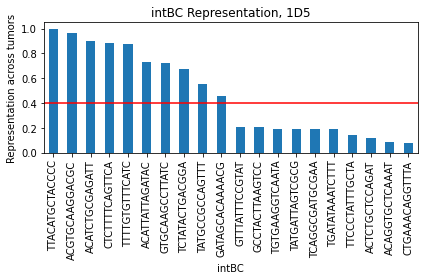

In [11]:
clone = '1D5'
consensus_filter_bound = 0.4

props = es_rep_dfs[clone].copy()
props[props >= 0.1] = 1
props[props < 0.1] = 0

props2 = props.apply(lambda x: np.sum(x>0) / len(x)).to_frame().reset_index()
props2.columns = ['intBC', 'prop']
props2 = props2.loc[props2['prop'] > 0]

props2.index = props2.intBC
props2 = props2.sort_values(by = 'prop', ascending=False)

ibcs = props2[props2['prop'] > consensus_filter_bound].index  

plt.close()
props2[props2['prop'] > 0.05]['prop'].plot(kind = 'bar')
plt.axhline(y = consensus_filter_bound, color='red')
plt.ylabel('Representation across tumors')
plt.title('intBC Representation, ' + clone)
plt.tight_layout()
plt.show()

## Figures with filtered allele table

The plots below are made with a completely filtered allele table - after filtering out "normal" cells with few cut intBCs and subsetting intBCs to only those identified as consensus intBCs.

In [17]:
allele_table_final = pd.read_csv(f"{data_directory}/KPTracer.alleleTable.FINAL.txt", sep='\t', converters={"ES_clone": str})

In [18]:
at_piv = pd.pivot_table(allele_table_final, index="cellBC", columns="intBC", values="UMI", aggfunc="sum")
at_piv.fillna(value = 0, inplace=True)
at_piv[at_piv > 0] = 1

es_rep_dfs = {}

for esc in tqdm_notebook(es_clones):
    
    if type(esc) != str:
        continue
    
    tumors = allele_table_final.loc[allele_table_final['ES_clone'] == esc, 'Tumor'].unique()
    tumor_dict = {}
    
    for tumor in tumors:
    
        cells = allele_table_final.loc[allele_table_final['Tumor'] == tumor, 'cellBC'].unique()
        tumor_piv = at_piv.loc[cells]
        
        if tumor_piv.shape[0] == 0:
            continue
            
        tumor_piv = tumor_piv.loc[:, tumor_piv.sum(axis=0) > 0]
            
        props = tumor_piv.apply(lambda x: np.sum(x>0) / len(x)).to_frame().reset_index()
        props.columns = ['intBC', 'prop']

        props = props.sort_values(by = 'prop', ascending=False)
        props = props[(props['intBC'] != 'NC')]

        props.index = props.intBC

        tumor_dict[tumor] = props['prop'].to_dict()
    
    if len(tumor_dict) > 0:
        tumor_df = pd.DataFrame.from_dict(tumor_dict, orient='index')
        tumor_df.fillna(value = 0, inplace=True)
        es_rep_dfs[esc] = tumor_df

/home/eecs/mattjones/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/9 [00:00<?, ?it/s]

### Figure 1D: intBC expression

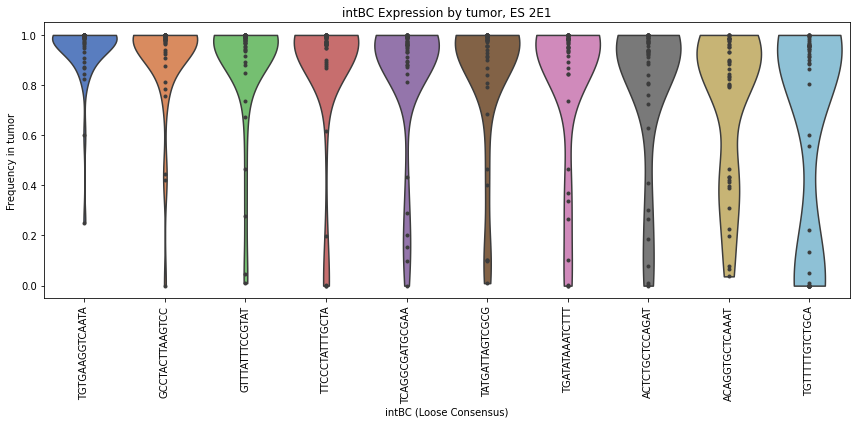

In [19]:
clone = '2E1'
ibcs = allele_table_final.loc[allele_table_final['ES_clone'] == clone, 'intBC'].unique()
ibcs = es_rep_dfs[clone][ibcs].mean(axis=0).sort_values(ascending=False).index.values

melted = pd.melt(es_rep_dfs[clone][ibcs])
h = plt.figure(figsize=(12, 6))
ax = sns.violinplot(x="variable", y="value",
            data=melted, palette="muted", inner='point', cut=0, scale='count')
plt.xticks(rotation = 90)
plt.xlabel('intBC (Loose Consensus)')
plt.ylabel('Frequency in tumor')
plt.title('intBC Expression by tumor, ES ' +  clone)

plt.tight_layout()

### Figure S1G: intBC / cellBC pivot

In [28]:
clone_sizes = allele_table_final.groupby('ES_clone').agg({'cellBC': 'nunique'}).sort_values(by = 'cellBC')

# order tumors by ES clone ident
cell_ordering = []
es_annotation = []
es_to_intbcs = {}
for es in tqdm_notebook(clone_sizes.index):
    all_tumors = allele_table_final.loc[allele_table_final['ES_clone'] == es, 'Tumor'].unique()
    
    intBCs = allele_table_final.loc[allele_table_final['ES_clone'] == es, 'intBC'].value_counts().sort_values(ascending=False).index
    es_to_intbcs[es] = intBCs
    
    tumors = []
    for tumor in all_tumors:
        if tumor in tumor_list['Tumor'].tolist():
            tumors.append(tumor)

    for tumor in tumors:
        cells = allele_table_final.loc[allele_table_final['Tumor'] == tumor, 'cellBC'].unique()
        cell_ordering += list(cells)
        es_annotation += [es]*len(cells)

at_piv = pd.pivot_table(allele_table_final, columns='intBC', index='cellBC', values='UMI')
at_piv[at_piv > 0] = 1

at_piv = at_piv.loc[cell_ordering]

/home/eecs/mattjones/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/6 [00:00<?, ?it/s]

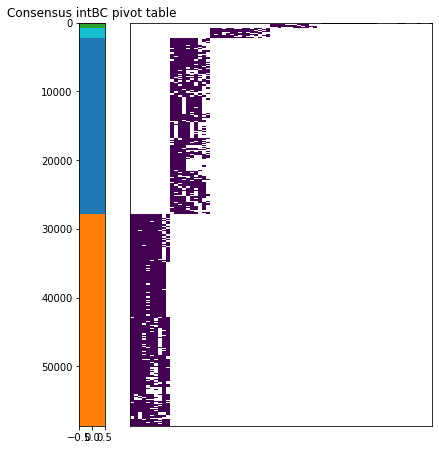

In [29]:
all_consensus_ibcs = []
for es_clone in clone_sizes.index[::-1]:
    if es_clone in es_annotation:
        all_consensus_ibcs += list(es_to_intbcs[es_clone])

colors = list(plt.get_cmap('tab10').colors)
module_colors = {j: colors[(i-1) % len(colors)] for i, j in zip(range(len(np.unique(es_annotation))), np.unique(es_annotation))}

row_colors = pd.Series([module_colors[i] for i in es_annotation], index = at_piv.index)
cbar_mat = np.zeros((len(row_colors), 1, 3))
for r in range(len(row_colors)):
    cbar_mat[r, 0, :] = row_colors.iloc[r][0], row_colors.iloc[r][1], row_colors.iloc[r][2]

h2 = plt.figure(2,figsize=(7,7))
axmat2 = h2.add_axes([0.3,0.1,0.6,0.8])
im2 = axmat2.matshow(at_piv[all_consensus_ibcs], aspect='auto', origin='upper')
axmat2.set_yticks([])
axmat2.set_xticks([])

cbar = h2.add_axes([0.2, 0.1, 0.05, 0.8])
im3 = cbar.imshow(cbar_mat, aspect='auto', origin='upper', interpolation="none")

plt.title('Consensus intBC pivot table')
plt.show()

### Figure S1H: Tumor Quality-Control

In [21]:
tumor_stats = {}
tum_errors = []
numerr = 0

for tumor, tum_at in allele_table_final.groupby('Tumor'):
        
    clone = meta.loc[meta['Tumor'] == tumor, 'ES_clone'].iloc[0]

    tumor_at = allele_table_final[allele_table_final['Tumor'] == tumor].copy()
    tumor_at['lineageGrp'] = tumor_at['Tumor'].copy()
    lg = lg_util.collectAlleles(tumor_at, thresh=0.2)[0]

    # drop normal cells from lg
    n_cs = len(lg['intBC'].unique())*3
    filt = lg.apply(lambda x: not meta.loc[x.cellBC, 'is_normal'], axis=1)
    lg = lg.loc[filt]
    
    try:
        cm, priors, state2indel = util.alleletable_to_character_matrix(lg, write=False, allele_rep_thresh = 0.98)
    except:
        cm, priors, state2indel = util.alleletable_to_character_matrix(lg, write=False, allele_rep_thresh = 1.0)
    
    number_dropped_intbcs = (n_cs - cm.shape[1]) 
    pu = cm.apply(lambda x: percent_uncut(x.values), axis=1)

    cmf = cm[pu < 0.8]

    puniq = cmf.drop_duplicates().shape[0] / cmf.shape[0]
    tumor_stats[tumor] = (puniq, compute_perc_indels(cmf), number_dropped_intbcs, 1.0 - (number_dropped_intbcs / n_cs), cmf.shape[0])

Processing characters: 100%|██████████| 4/4 [00:00<00:00, 1480.91it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTTTGTGTTTCATC_r2', 'TTTTGTGTTTCATC_r3', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'ACATTATTAGATAC_r1', 'ACATTATTAGATAC_r2', 'ACATTATTAGATAC_r3']



Processing characters: 100%|██████████| 9/9 [00:00<00:00, 3359.33it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'ACATCTGCGAGATT_r1', 'ACATCTGCGAGATT_r2', 'ACATTATTAGATAC_r1', 'ACATTATTAGATAC_r2', 'ACATTATTAGATAC_r3', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'GATAGCACAAAACG_r3', 'TCTATACTGACGGA_r1', 'TCTATACTGACGGA_r2', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTTTGTGTTTCATC_r2']



100%|██████████| 1/1 [00:00<00:00, 184.19it/s]
Processing characters: 0it [00:00, ?it/s]
Processing characters: 100%|██████████| 26/26 [00:00<00:00, 36038.30it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTTTGTGTTTCATC_r1', 'TTTTGTGTTTCATC_r2', 'TTTTGTGTTTCATC_r3', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'ACATTATTAGATAC_r1', 'ACATTATTAGATAC_r2', 'ACATTATTAGATAC_r3']
Dropping the following intBCs due to lack of diversity with threshold 1.0: []
Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACGTGCAAGGACGC_r3']


Processing characters: 100%|██████████| 27/27 [00:00<00:00, 9170.48it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CTCTTTTCAGTTCA_r1', 'GATAGCACAAAACG_r3', 'TTTTGTGTTTCATC_r1']



Processing characters: 100%|██████████| 23/23 [00:00<00:00, 10334.12it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACGTGCAAGGACGC_r1', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'TTTTGTGTTTCATC_r1']



100%|██████████| 1/1 [00:00<00:00, 134.18it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TATGCCGCCAGTTT_r1', 'TATGCCGCCAGTTT_r2', 'TTTTGTGTTTCATC_r1', 'TTTTGTGTTTCATC_r2', 'TTTTGTGTTTCATC_r3', 'TCTATACTGACGGA_r1', 'TCTATACTGACGGA_r2', 'TCTATACTGACGGA_r3']


Processing characters: 100%|██████████| 13/13 [00:00<00:00, 6951.29it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TATGCCGCCAGTTT_r1', 'TATGCCGCCAGTTT_r2', 'TTACATGCTACCCC_r2', 'TTTTGTGTTTCATC_r1', 'TTTTGTGTTTCATC_r2', 'ACATCTGCGAGATT_r1', 'ACATCTGCGAGATT_r2', 'TCTATACTGACGGA_r2']



Processing characters: 100%|██████████| 4/4 [00:00<00:00, 955.69it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACATTATTAGATAC_r1', 'ACATTATTAGATAC_r2', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'ACATCTGCGAGATT_r1', 'ACATCTGCGAGATT_r2', 'ACATCTGCGAGATT_r3', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'GTGCAAGCCTTATC_r1', 'GTGCAAGCCTTATC_r2', 'GATAGCACAAAACG_r2', 'TATGCCGCCAGTTT_r1', 'TATGCCGCCAGTTT_r2', 'TATGCCGCCAGTTT_r3', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3']



Processing characters: 100%|██████████| 30/30 [00:00<00:00, 1701.24it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: []



Processing characters: 100%|██████████| 9/9 [00:00<00:00, 843.74it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'ACATTATTAGATAC_r1', 'ACATTATTAGATAC_r2', 'TCTATACTGACGGA_r1', 'TTTTGTGTTTCATC_r2']



Processing characters: 100%|██████████| 30/30 [00:00<00:00, 1884.15it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: []



Processing characters: 100%|██████████| 30/30 [00:00<00:00, 6282.97it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: []



Processing characters: 100%|██████████| 29/29 [00:00<00:00, 6842.64it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TATGCCGCCAGTTT_r1']



Processing characters: 100%|██████████| 22/22 [00:00<00:00, 12397.51it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'GTGCAAGCCTTATC_r3', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTTTGTGTTTCATC_r1']


Processing characters: 100%|██████████| 6/6 [00:00<00:00, 2059.40it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTTTGTGTTTCATC_r1', 'TTTTGTGTTTCATC_r2', 'TTTTGTGTTTCATC_r3', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3', 'TCTATACTGACGGA_r1', 'TCTATACTGACGGA_r2', 'TCTATACTGACGGA_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'ACATCTGCGAGATT_r2', 'ACATTATTAGATAC_r1', 'ACATTATTAGATAC_r2', 'ACATTATTAGATAC_r3']



100%|██████████| 1/1 [00:00<00:00, 144.17it/s]
Processing characters: 0it [00:00, ?it/s]
Processing characters: 100%|██████████| 21/21 [00:00<00:00, 12954.90it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTTTGTGTTTCATC_r1', 'TTTTGTGTTTCATC_r2', 'TTTTGTGTTTCATC_r3', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3', 'TCTATACTGACGGA_r1', 'TCTATACTGACGGA_r2', 'TCTATACTGACGGA_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'ACATTATTAGATAC_r1', 'ACATTATTAGATAC_r2', 'ACATTATTAGATAC_r3', 'ACATCTGCGAGATT_r1', 'ACATCTGCGAGATT_r2', 'ACATCTGCGAGATT_r3']
Dropping the following intBCs due to lack of diversity with threshold 1.0: []



100%|██████████| 1/1 [00:00<00:00, 116.78it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACATTATTAGATAC_r1', 'ACATTATTAGATAC_r2', 'ACATTATTAGATAC_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'ACATCTGCGAGATT_r1', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3', 'TCTATACTGACGGA_r2', 'TCTATACTGACGGA_r3', 'TTTTGTGTTTCATC_r1', 'TTTTGTGTTTCATC_r2', 'TTTTGTGTTTCATC_r3']
Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTTTGTGTTTCATC_r1', 'TTTTGTGTTTCATC_r2', 'TTTTGTGTTTCATC_r3', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3', 'TCTATACTGACGGA_r1', 'TCTATACTGACGGA_r2', 'TCTATACTGACGGA_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'ACATTATTAGATAC_r1', 'ACATTATTAGATAC_r2', 'ACATTATTAGATAC_r3', 'ACATCTGCGAGATT_r1', 'ACATCTGCGAGATT_r2']



Processing characters: 100%|██████████| 3/3 [00:00<00:00, 2871.50it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'ACATTATTAGATAC_r1', 'ACATTATTAGATAC_r2', 'ACATTATTAGATAC_r3', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'TTTTGTGTTTCATC_r1', 'TTTTGTGTTTCATC_r2', 'TTTTGTGTTTCATC_r3', 'TCTATACTGACGGA_r1', 'TCTATACTGACGGA_r2', 'TCTATACTGACGGA_r3', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3', 'ACATCTGCGAGATT_r2']



100%|██████████| 1/1 [00:00<00:00, 135.63it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TCTATACTGACGGA_r1', 'TCTATACTGACGGA_r2', 'TCTATACTGACGGA_r3', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'ACATTATTAGATAC_r1', 'ACATTATTAGATAC_r2', 'ACATTATTAGATAC_r3', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3', 'TTTTGTGTTTCATC_r1', 'TTTTGTGTTTCATC_r2', 'TTTTGTGTTTCATC_r3', 'ACATCTGCGAGATT_r2', 'GATAGCACAAAACG_r3']


Processing characters: 100%|██████████| 3/3 [00:00<00:00, 6894.75it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTTTGTGTTTCATC_r1', 'TTTTGTGTTTCATC_r2', 'TTTTGTGTTTCATC_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'ACATTATTAGATAC_r1', 'ACATTATTAGATAC_r2', 'ACATTATTAGATAC_r3', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3', 'TCTATACTGACGGA_r1', 'TCTATACTGACGGA_r2', 'TCTATACTGACGGA_r3', 'ACATCTGCGAGATT_r2']



Processing characters: 100%|██████████| 24/24 [00:00<00:00, 35887.09it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TATGCCGCCAGTTT_r1', 'TATGCCGCCAGTTT_r2', 'TATGCCGCCAGTTT_r3']


Processing characters: 100%|██████████| 19/19 [00:00<00:00, 22148.91it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TCTATACTGACGGA_r2', 'TCTATACTGACGGA_r3']


100%|██████████| 1/1 [00:00<00:00, 179.29it/s]
Processing characters: 0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00, 122.45it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACATCTGCGAGATT_r1', 'ACATCTGCGAGATT_r2', 'ACATCTGCGAGATT_r3', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'ACATTATTAGATAC_r1', 'ACATTATTAGATAC_r2', 'ACATTATTAGATAC_r3', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3', 'GTGCAAGCCTTATC_r1', 'GTGCAAGCCTTATC_r2', 'GTGCAAGCCTTATC_r3']
Dropping the following intBCs due to lack of diversity with threshold 1.0: []


Processing characters: 100%|██████████| 4/4 [00:00<00:00, 4656.46it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TCTATACTGACGGA_r1', 'TCTATACTGACGGA_r2', 'GTGCAAGCCTTATC_r1', 'GTGCAAGCCTTATC_r2', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'ACATTATTAGATAC_r1', 'ACATTATTAGATAC_r2', 'ACATTATTAGATAC_r3', 'ACATCTGCGAGATT_r1', 'ACATCTGCGAGATT_r2']



Processing characters: 100%|██████████| 15/15 [00:00<00:00, 3254.09it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TCTATACTGACGGA_r1', 'TCTATACTGACGGA_r2', 'GTGCAAGCCTTATC_r2', 'GATAGCACAAAACG_r2', 'GATAGCACAAAACG_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'ACGTGCAAGGACGC_r1']



100%|██████████| 1/1 [00:00<00:00, 96.06it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACGTGCAAGGACGC_r1', 'GTGCAAGCCTTATC_r2', 'TATGCCGCCAGTTT_r1', 'TATGCCGCCAGTTT_r2', 'TATGCCGCCAGTTT_r3', 'TTTTGTGTTTCATC_r1', 'TTTTGTGTTTCATC_r2', 'TTTTGTGTTTCATC_r3']


Processing characters: 100%|██████████| 15/15 [00:00<00:00, 1948.00it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CTCTTTTCAGTTCA_r1', 'ACATCTGCGAGATT_r1', 'ACATCTGCGAGATT_r2', 'ACATTATTAGATAC_r1', 'ACATTATTAGATAC_r2', 'ACGTGCAAGGACGC_r2', 'TTACATGCTACCCC_r2', 'GTGCAAGCCTTATC_r1', 'GTGCAAGCCTTATC_r2']



Processing characters: 100%|██████████| 13/13 [00:00<00:00, 12316.68it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACATTATTAGATAC_r2', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'TTACATGCTACCCC_r2', 'TTTTGTGTTTCATC_r2']


Processing characters: 100%|██████████| 10/10 [00:00<00:00, 3060.64it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTTTGTGTTTCATC_r1', 'TTTTGTGTTTCATC_r2', 'TTTTGTGTTTCATC_r3', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3', 'TATGCCGCCAGTTT_r2', 'GTGCAAGCCTTATC_r2', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'ACATTATTAGATAC_r1', 'ACATTATTAGATAC_r2', 'ACATTATTAGATAC_r3', 'ACATCTGCGAGATT_r1', 'ACATCTGCGAGATT_r2']



Processing characters: 100%|██████████| 2/2 [00:00<00:00, 14122.24it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3', 'TATGCCGCCAGTTT_r1', 'TATGCCGCCAGTTT_r2', 'TATGCCGCCAGTTT_r3', 'GTGCAAGCCTTATC_r2', 'GTGCAAGCCTTATC_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'ACATTATTAGATAC_r1', 'ACATTATTAGATAC_r2', 'ACATTATTAGATAC_r3', 'ACATCTGCGAGATT_r1', 'ACATCTGCGAGATT_r2', 'ACATCTGCGAGATT_r3', 'GATAGCACAAAACG_r1', 'GATAGCACAAAACG_r2', 'GATAGCACAAAACG_r3']
Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GTGCAAGCCTTATC_r2', 'GTGCAAGCCTTATC_r3', 'ACATCTGCGAGATT_r1', 'ACATCTGCGAGATT_r2', 'ACATCTGCGAGATT_r3', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'TCTATACTGACGGA_r2', 'TCTATACTGACGGA_r3', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3', 'TTTTGTGTTTCATC_r1', 'TTTTG


100%|██████████| 1/1 [00:00<00:00, 106.05it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTTTGTGTTTCATC_r1', 'TTTTGTGTTTCATC_r2', 'TTTTGTGTTTCATC_r3', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3', 'TCTATACTGACGGA_r2', 'TCTATACTGACGGA_r3', 'GTGCAAGCCTTATC_r1', 'GTGCAAGCCTTATC_r2', 'GTGCAAGCCTTATC_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'ACATCTGCGAGATT_r1', 'ACATCTGCGAGATT_r2', 'ACATCTGCGAGATT_r3', 'GATAGCACAAAACG_r1', 'GATAGCACAAAACG_r2', 'GATAGCACAAAACG_r3']
Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3', 'TATGCCGCCAGTTT_r1', 'TATGCCGCCAGTTT_r2', 'TATGCCGCCAGTTT_r3', 'GTGCAAGCCTTATC_r1', 'GTGCAAGCCTTATC_r2', 'GTGCAAGCCTTATC_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'ACATTATTAGATAC_r2', 'ACATTATTAGATAC_r3', 'ACATC

Processing characters: 100%|██████████| 25/25 [00:00<00:00, 2849.24it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2']



Processing characters: 100%|██████████| 9/9 [00:00<00:00, 7019.10it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACATCTGCGAGATT_r2', 'ACATTATTAGATAC_r2', 'ACATTATTAGATAC_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'GATAGCACAAAACG_r3', 'GTGCAAGCCTTATC_r1', 'GTGCAAGCCTTATC_r2', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTTTGTGTTTCATC_r2']



Processing characters: 100%|██████████| 2/2 [00:00<00:00, 3818.21it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'TTTTGTGTTTCATC_r1', 'TTTTGTGTTTCATC_r2', 'TTTTGTGTTTCATC_r3', 'TATGCCGCCAGTTT_r1', 'TATGCCGCCAGTTT_r2', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3', 'TCTATACTGACGGA_r1', 'TCTATACTGACGGA_r2', 'TCTATACTGACGGA_r3']



Processing characters: 100%|██████████| 9/9 [00:00<00:00, 4810.59it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GATAGCACAAAACG_r1', 'GATAGCACAAAACG_r2', 'ACATCTGCGAGATT_r1', 'ACATCTGCGAGATT_r2', 'ACATCTGCGAGATT_r3', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'CTCTTTTCAGTTCA_r2', 'TTACATGCTACCCC_r2', 'GTGCAAGCCTTATC_r2', 'TCTATACTGACGGA_r2', 'TCTATACTGACGGA_r3', 'TTTTGTGTTTCATC_r2', 'TTTTGTGTTTCATC_r3']



Processing characters: 100%|██████████| 24/24 [00:00<00:00, 9407.78it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: []


Processing characters: 100%|██████████| 15/15 [00:00<00:00, 4093.34it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GATAGCACAAAACG_r1', 'GATAGCACAAAACG_r2', 'GATAGCACAAAACG_r3']



Processing characters: 100%|██████████| 27/27 [00:00<00:00, 11085.18it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: []


Processing characters: 100%|██████████| 8/8 [00:00<00:00, 3291.59it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTTTGTGTTTCATC_r1', 'TTTTGTGTTTCATC_r2', 'TCTATACTGACGGA_r1', 'TCTATACTGACGGA_r2', 'TCTATACTGACGGA_r3', 'TATGCCGCCAGTTT_r1', 'TATGCCGCCAGTTT_r2', 'TATGCCGCCAGTTT_r3', 'GTGCAAGCCTTATC_r2', 'GTGCAAGCCTTATC_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'ACATTATTAGATAC_r1', 'ACATTATTAGATAC_r2', 'ACATTATTAGATAC_r3', 'ACATCTGCGAGATT_r1', 'ACATCTGCGAGATT_r2', 'TTACATGCTACCCC_r2']



100%|██████████| 1/1 [00:00<00:00, 131.91it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACATCTGCGAGATT_r1', 'ACATTATTAGATAC_r1', 'ACATTATTAGATAC_r2', 'ACATTATTAGATAC_r3', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'GTGCAAGCCTTATC_r2', 'GTGCAAGCCTTATC_r3', 'TTTTGTGTTTCATC_r1', 'TATGCCGCCAGTTT_r1', 'TATGCCGCCAGTTT_r2', 'TATGCCGCCAGTTT_r3', 'TTACATGCTACCCC_r2', 'TCTATACTGACGGA_r1', 'TCTATACTGACGGA_r2', 'TCTATACTGACGGA_r3']


Processing characters: 100%|██████████| 3/3 [00:00<00:00, 28926.23it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTTTGTGTTTCATC_r1', 'TTACATGCTACCCC_r2', 'TATGCCGCCAGTTT_r1', 'TATGCCGCCAGTTT_r2', 'TATGCCGCCAGTTT_r3', 'GTGCAAGCCTTATC_r2', 'GTGCAAGCCTTATC_r3', 'GATAGCACAAAACG_r1', 'GATAGCACAAAACG_r2', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'ACATTATTAGATAC_r1', 'ACATTATTAGATAC_r2', 'ACATTATTAGATAC_r3', 'ACATCTGCGAGATT_r1', 'ACATCTGCGAGATT_r3', 'TCTATACTGACGGA_r1', 'TCTATACTGACGGA_r2', 'TCTATACTGACGGA_r3']
Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTTTGTGTTTCATC_r1', 'TTTTGTGTTTCATC_r2', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TATGCCGCCAGTTT_r1', 'TATGCCGCCAGTTT_r2', 'TATGCCGCCAGTTT_r3', 'GTGCAAGCCTTATC_r1', 'GTGCAAGCCTTATC_r2', 'GTGCAAGCCTTATC_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'ACATTATTAGATAC_r1', 'ACATT

100%|██████████| 1/1 [00:00<00:00, 132.02it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACATTATTAGATAC_r1', 'ACATTATTAGATAC_r2', 'ACATTATTAGATAC_r3', 'ACATCTGCGAGATT_r1', 'ACATCTGCGAGATT_r2', 'GTGCAAGCCTTATC_r2', 'GTGCAAGCCTTATC_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'TATGCCGCCAGTTT_r1', 'TATGCCGCCAGTTT_r2', 'TATGCCGCCAGTTT_r3', 'TTACATGCTACCCC_r2', 'TTTTGTGTTTCATC_r1', 'TCTATACTGACGGA_r1', 'TCTATACTGACGGA_r2', 'TCTATACTGACGGA_r3']


Processing characters: 100%|██████████| 10/10 [00:00<00:00, 12606.87it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'ACATCTGCGAGATT_r1', 'ACATTATTAGATAC_r1', 'ACATTATTAGATAC_r2', 'ACATTATTAGATAC_r3', 'GTGCAAGCCTTATC_r2', 'GTGCAAGCCTTATC_r3', 'TATGCCGCCAGTTT_r1', 'TATGCCGCCAGTTT_r2', 'TATGCCGCCAGTTT_r3', 'TTACATGCTACCCC_r2', 'TCTATACTGACGGA_r1', 'TCTATACTGACGGA_r2', 'TCTATACTGACGGA_r3', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'TTTTGTGTTTCATC_r1']


Processing characters: 100%|██████████| 10/10 [00:00<00:00, 3687.62it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTACATGCTACCCC_r2', 'TCTATACTGACGGA_r1', 'TCTATACTGACGGA_r2', 'TCTATACTGACGGA_r3', 'TATGCCGCCAGTTT_r1', 'TATGCCGCCAGTTT_r2', 'TATGCCGCCAGTTT_r3', 'GTGCAAGCCTTATC_r2', 'GTGCAAGCCTTATC_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'ACATTATTAGATAC_r1', 'ACATTATTAGATAC_r2', 'ACATTATTAGATAC_r3', 'ACATCTGCGAGATT_r1', 'TTTTGTGTTTCATC_r1']



Processing characters: 100%|██████████| 10/10 [00:00<00:00, 21498.23it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TATGCCGCCAGTTT_r1', 'TATGCCGCCAGTTT_r2', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'GTGCAAGCCTTATC_r1', 'GTGCAAGCCTTATC_r2', 'ACATCTGCGAGATT_r2', 'ACATCTGCGAGATT_r3', 'TCTATACTGACGGA_r2', 'TCTATACTGACGGA_r3', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3', 'TTTTGTGTTTCATC_r1', 'TTTTGTGTTTCATC_r2', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3']


Processing characters: 100%|██████████| 13/13 [00:00<00:00, 14716.86it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GTGCAAGCCTTATC_r1', 'GTGCAAGCCTTATC_r2']


100%|██████████| 1/1 [00:00<00:00, 127.53it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GTGCAAGCCTTATC_r1', 'GTGCAAGCCTTATC_r2', 'GTGCAAGCCTTATC_r3', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'ACATCTGCGAGATT_r1', 'ACATCTGCGAGATT_r2', 'ACATCTGCGAGATT_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'TTTTGTGTTTCATC_r2', 'TTTTGTGTTTCATC_r3', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3']


Processing characters: 100%|██████████| 2/2 [00:00<00:00, 4725.98it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTTTGTGTTTCATC_r2', 'TTTTGTGTTTCATC_r3', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'GTGCAAGCCTTATC_r1', 'GTGCAAGCCTTATC_r2', 'GTGCAAGCCTTATC_r3', 'ACATCTGCGAGATT_r1', 'ACATCTGCGAGATT_r2', 'ACATCTGCGAGATT_r3', 'GATAGCACAAAACG_r1', 'GATAGCACAAAACG_r2']



Processing characters: 100%|██████████| 2/2 [00:00<00:00, 5162.22it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GTGCAAGCCTTATC_r1', 'GTGCAAGCCTTATC_r2', 'GTGCAAGCCTTATC_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'GATAGCACAAAACG_r1', 'GATAGCACAAAACG_r2', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3', 'TTTTGTGTTTCATC_r2', 'TTTTGTGTTTCATC_r3', 'ACATCTGCGAGATT_r1', 'ACATCTGCGAGATT_r2', 'ACATCTGCGAGATT_r3']



100%|██████████| 1/1 [00:00<00:00, 139.73it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'TTTTGTGTTTCATC_r2', 'TTTTGTGTTTCATC_r3', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3', 'GTGCAAGCCTTATC_r1', 'GTGCAAGCCTTATC_r2', 'GTGCAAGCCTTATC_r3', 'GATAGCACAAAACG_r1', 'GATAGCACAAAACG_r2', 'GATAGCACAAAACG_r3', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'ACATCTGCGAGATT_r1', 'ACATCTGCGAGATT_r2', 'ACATCTGCGAGATT_r3']


100%|██████████| 1/1 [00:00<00:00, 176.96it/s]
Processing characters: 0it [00:00, ?it/s]
Processing characters: 100%|██████████| 18/18 [00:00<00:00, 151297.54it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACATCTGCGAGATT_r1', 'ACATCTGCGAGATT_r2', 'ACATCTGCGAGATT_r3', 'GTGCAAGCCTTATC_r1', 'GTGCAAGCCTTATC_r2', 'GTGCAAGCCTTATC_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3', 'TTTTGTGTTTCATC_r2', 'TTTTGTGTTTCATC_r3', 'GATAGCACAAAACG_r1', 'GATAGCACAAAACG_r2']
Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTTTGTGTTTCATC_r1', 'TTTTGTGTTTCATC_r2', 'TTTTGTGTTTCATC_r3', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3', 'GATAGCACAAAACG_r1', 'GATAGCACAAAACG_r2', 'GATAGCACAAAACG_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'ACATCTGCGAGATT_r1', 'ACATCTGCGAGATT_r2', 'ACATCTGCGAGATT_r3']
Dropping the following intBCs due to lack of diversity with threshold


100%|██████████| 1/1 [00:00<00:00, 170.04it/s]
Processing characters: 0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00, 135.02it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GATAGCACAAAACG_r1', 'GATAGCACAAAACG_r2', 'GATAGCACAAAACG_r3', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'ACATCTGCGAGATT_r1', 'ACATCTGCGAGATT_r2', 'ACATCTGCGAGATT_r3', 'GTGCAAGCCTTATC_r1', 'GTGCAAGCCTTATC_r2', 'GTGCAAGCCTTATC_r3', 'TTTTGTGTTTCATC_r1', 'TTTTGTGTTTCATC_r2', 'TTTTGTGTTTCATC_r3', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3']
Dropping the following intBCs due to lack of diversity with threshold 1.0: []


100%|██████████| 1/1 [00:00<00:00, 146.75it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTTTGTGTTTCATC_r2', 'TTTTGTGTTTCATC_r3', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3', 'GTGCAAGCCTTATC_r1', 'GTGCAAGCCTTATC_r2', 'GTGCAAGCCTTATC_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'ACATCTGCGAGATT_r1', 'ACATCTGCGAGATT_r2', 'ACATCTGCGAGATT_r3', 'GATAGCACAAAACG_r1', 'GATAGCACAAAACG_r2', 'GATAGCACAAAACG_r3']



100%|██████████| 1/1 [00:00<00:00, 146.51it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GATAGCACAAAACG_r1', 'GATAGCACAAAACG_r2', 'ACATCTGCGAGATT_r1', 'ACATCTGCGAGATT_r2', 'ACATCTGCGAGATT_r3', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'GTGCAAGCCTTATC_r1', 'GTGCAAGCCTTATC_r2', 'GTGCAAGCCTTATC_r3', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3', 'TTTTGTGTTTCATC_r2', 'TTTTGTGTTTCATC_r3']



Processing characters: 100%|██████████| 7/7 [00:00<00:00, 15196.75it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'GTGCAAGCCTTATC_r1', 'GTGCAAGCCTTATC_r2', 'GTGCAAGCCTTATC_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'TTTTGTGTTTCATC_r2', 'TTTTGTGTTTCATC_r3', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3']


Processing characters: 100%|██████████| 19/19 [00:00<00:00, 28060.48it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2']


Processing characters: 100%|██████████| 16/16 [00:00<00:00, 6483.95it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACATTATTAGATAC_r2', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'GTGCAAGCCTTATC_r3', 'TTTTGTGTTTCATC_r1', 'TTTTGTGTTTCATC_r2', 'TTTTGTGTTTCATC_r3']



Processing characters: 100%|██████████| 19/19 [00:00<00:00, 7462.48it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'TCTATACTGACGGA_r2', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2']



Processing characters: 100%|██████████| 24/24 [00:00<00:00, 11096.04it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: []


100%|██████████| 1/1 [00:00<00:00, 124.41it/s]
Processing characters: 0it [00:00, ?it/s]
Processing characters: 100%|██████████| 24/24 [00:00<00:00, 110014.53it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TATGCCGCCAGTTT_r1', 'ACATTATTAGATAC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'CTCTTTTCAGTTCA_r2', 'TCTATACTGACGGA_r2', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTTTGTGTTTCATC_r2']
Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTTTGTGTTTCATC_r1', 'TTTTGTGTTTCATC_r2', 'TTTTGTGTTTCATC_r3', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3', 'TCTATACTGACGGA_r1', 'TCTATACTGACGGA_r2', 'TCTATACTGACGGA_r3', 'TATGCCGCCAGTTT_r1', 'TATGCCGCCAGTTT_r2', 'TATGCCGCCAGTTT_r3', 'GATAGCACAAAACG_r1', 'GATAGCACAAAACG_r2', 'GATAGCACAAAACG_r3', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'ACATTATTAGATAC_r1', 'ACATTATTAGATAC_r2', 'ACATTATTAGATAC_r3']
Dropping the following intBCs due to lack of diversity with threshold 1.0: []



Processing characters: 100%|██████████| 24/24 [00:00<00:00, 17334.82it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: []


Processing characters: 100%|██████████| 27/27 [00:00<00:00, 18411.02it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: []


Processing characters: 100%|██████████| 21/21 [00:00<00:00, 3066.01it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: []



100%|██████████| 1/1 [00:00<00:00, 124.11it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTTCGTCGCTCTTC_r1', 'TTTCGTCGCTCTTC_r2', 'TTTCGTCGCTCTTC_r3', 'TAACCAAGCCTACA_r1', 'TAACCAAGCCTACA_r2', 'TAACCAAGCCTACA_r3', 'GCGTTTAGAATATT_r1', 'GCGTTTAGAATATT_r2', 'GCGTTTAGAATATT_r3', 'GCCTTCAATTCCAA_r1', 'GCCTTCAATTCCAA_r2', 'GCCTTCAATTCCAA_r3', 'GAACCCACAATTCC_r1', 'GAACCCACAATTCC_r2', 'GAACCCACAATTCC_r3', 'CGCTATGGGGGGAA_r2', 'CGCTATGGGGGGAA_r3', 'CGATTGGTCACTTA_r1', 'CGATTGGTCACTTA_r2', 'CGATTGGTCACTTA_r3', 'ATGATTTAACTACT_r1', 'ATGATTTAACTACT_r2', 'ATGATTTAACTACT_r3']


Processing characters: 100%|██████████| 35/35 [00:00<00:00, 15159.09it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TAACCAAGCCTACA_r2']



Processing characters: 100%|██████████| 28/28 [00:00<00:00, 13674.95it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ATGATTTAACTACT_r1', 'ATGATTTAACTACT_r3', 'CGATTGGTCACTTA_r1', 'CGATTGGTCACTTA_r2', 'CGATTGGTCACTTA_r3', 'GAACCCACAATTCC_r2', 'GAACCCACAATTCC_r3', 'ACAATGCGTGTGGC_r1']



Processing characters: 100%|██████████| 28/28 [00:00<00:00, 10673.50it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TAACCAAGCCTACA_r2', 'ATGATTTAACTACT_r1']



Processing characters: 100%|██████████| 34/34 [00:00<00:00, 832.60it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CGATTGGTCACTTA_r1', 'TAACCAAGCCTACA_r2']



Processing characters: 100%|██████████| 4/4 [00:00<00:00, 34100.03it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TATGATTAGTCGCG_r1', 'TATGATTAGTCGCG_r2', 'TATGATTAGTCGCG_r3', 'ACTCTGCTCCAGAT_r2', 'ACTCTGCTCCAGAT_r3', 'ACAGGTGCTCAAAT_r1', 'ACAGGTGCTCAAAT_r2', 'ACAGGTGCTCAAAT_r3', 'GTTTATTTCCGTAT_r1', 'GTTTATTTCCGTAT_r2', 'GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3', 'TCAGGCGATGCGAA_r2', 'TCAGGCGATGCGAA_r3', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TGTGAAGGTCAATA_r3', 'TTCCCTATTTGCTA_r1', 'TTCCCTATTTGCTA_r2', 'TGATATAAATCTTT_r1', 'TGATATAAATCTTT_r2', 'TGATATAAATCTTT_r3']
Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GTTTATTTCCGTAT_r1', 'GTTTATTTCCGTAT_r2', 'ACAGGTGCTCAAAT_r1', 'ACAGGTGCTCAAAT_r2', 'ACAGGTGCTCAAAT_r3', 'GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3', 'ACTCTGCTCCAGAT_r2', 'ACTCTGCTCCAGAT_r3', 'TATGATTAGTCGCG_r1', 'TATGATTAGTCGCG_r2', 'TATGATTAGTCGCG_r3', 'TCAGGCGATGCGAA_r2', 'TCAGGCGATGCGAA_r3', 'TGATATAAATCTTT_r1', 'TGATATAAATCTTT_r2', 'TGATA


100%|██████████| 1/1 [00:00<00:00, 132.15it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TATGATTAGTCGCG_r1', 'TATGATTAGTCGCG_r2', 'TATGATTAGTCGCG_r3', 'ACAGGTGCTCAAAT_r1', 'ACAGGTGCTCAAAT_r2', 'ACAGGTGCTCAAAT_r3', 'ACTCTGCTCCAGAT_r2', 'ACTCTGCTCCAGAT_r3', 'GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3', 'GTTTATTTCCGTAT_r1', 'GTTTATTTCCGTAT_r2', 'TCAGGCGATGCGAA_r2', 'TCAGGCGATGCGAA_r3', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TGTGAAGGTCAATA_r3', 'TTCCCTATTTGCTA_r1', 'TTCCCTATTTGCTA_r2', 'TGATATAAATCTTT_r1', 'TGATATAAATCTTT_r2', 'TGATATAAATCTTT_r3']



Processing characters: 100%|██████████| 4/4 [00:00<00:00, 7142.28it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACTCTGCTCCAGAT_r2', 'ACTCTGCTCCAGAT_r3', 'TCAGGCGATGCGAA_r2', 'TCAGGCGATGCGAA_r3', 'ACAGGTGCTCAAAT_r1', 'ACAGGTGCTCAAAT_r2', 'ACAGGTGCTCAAAT_r3', 'GTTTATTTCCGTAT_r1', 'GTTTATTTCCGTAT_r2', 'GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3', 'TGATATAAATCTTT_r1', 'TGATATAAATCTTT_r2', 'TGATATAAATCTTT_r3', 'TATGATTAGTCGCG_r1', 'TATGATTAGTCGCG_r2', 'TATGATTAGTCGCG_r3', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TGTGAAGGTCAATA_r3', 'TTCCCTATTTGCTA_r1', 'TTCCCTATTTGCTA_r2']



100%|██████████| 1/1 [00:00<00:00, 134.91it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TATGATTAGTCGCG_r1', 'TATGATTAGTCGCG_r2', 'TATGATTAGTCGCG_r3', 'ACAGGTGCTCAAAT_r1', 'ACAGGTGCTCAAAT_r2', 'ACAGGTGCTCAAAT_r3', 'ACTCTGCTCCAGAT_r2', 'ACTCTGCTCCAGAT_r3', 'GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3', 'GTTTATTTCCGTAT_r1', 'GTTTATTTCCGTAT_r2', 'TCAGGCGATGCGAA_r2', 'TCAGGCGATGCGAA_r3', 'TGATATAAATCTTT_r1', 'TGATATAAATCTTT_r2', 'TGATATAAATCTTT_r3', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TGTGAAGGTCAATA_r3', 'TTCCCTATTTGCTA_r1', 'TTCCCTATTTGCTA_r2']



Processing characters: 100%|██████████| 5/5 [00:00<00:00, 37315.87it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GTTTATTTCCGTAT_r1', 'GTTTATTTCCGTAT_r2', 'TTCCCTATTTGCTA_r1', 'TTCCCTATTTGCTA_r2', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TGTGAAGGTCAATA_r3', 'TGATATAAATCTTT_r1', 'TGATATAAATCTTT_r2', 'TGATATAAATCTTT_r3', 'TCAGGCGATGCGAA_r2', 'TCAGGCGATGCGAA_r3', 'TATGATTAGTCGCG_r1', 'TATGATTAGTCGCG_r2', 'TATGATTAGTCGCG_r3', 'GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3', 'ACTCTGCTCCAGAT_r2', 'ACTCTGCTCCAGAT_r3', 'ACAGGTGCTCAAAT_r1', 'ACAGGTGCTCAAAT_r2', 'ACAGGTGCTCAAAT_r3']
Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GTTTATTTCCGTAT_r1', 'GTTTATTTCCGTAT_r2', 'ACAGGTGCTCAAAT_r1', 'ACAGGTGCTCAAAT_r2', 'ACAGGTGCTCAAAT_r3', 'ACTCTGCTCCAGAT_r2', 'ACTCTGCTCCAGAT_r3', 'GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3', 'TCAGGCGATGCGAA_r2', 'TCAGGCGATGCGAA_r3', 'TATGATTAGTCGCG_r1', 'TATGATTAGTCGCG_r2', 'TATGATTAGTCGCG_r3', 'TGATATAAATCTTT_r1', 'TGATATAAATCTTT_r2', 'TGATA


Processing characters: 100%|██████████| 5/5 [00:00<00:00, 10618.49it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GTTTATTTCCGTAT_r1', 'GTTTATTTCCGTAT_r2', 'ACTCTGCTCCAGAT_r2', 'ACTCTGCTCCAGAT_r3', 'ACAGGTGCTCAAAT_r1', 'ACAGGTGCTCAAAT_r2', 'ACAGGTGCTCAAAT_r3', 'GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3', 'TTCCCTATTTGCTA_r1', 'TATGATTAGTCGCG_r1', 'TATGATTAGTCGCG_r2', 'TATGATTAGTCGCG_r3', 'TGATATAAATCTTT_r1', 'TGATATAAATCTTT_r2', 'TGATATAAATCTTT_r3', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TGTGAAGGTCAATA_r3', 'TCAGGCGATGCGAA_r2', 'TCAGGCGATGCGAA_r3']


Processing characters: 100%|██████████| 27/27 [00:00<00:00, 451.89it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: []



Processing characters: 100%|██████████| 16/16 [00:00<00:00, 5062.91it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTCCCTATTTGCTA_r1', 'TTCCCTATTTGCTA_r2', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3', 'ACTCTGCTCCAGAT_r2', 'ACTCTGCTCCAGAT_r3', 'TCAGGCGATGCGAA_r2', 'TCAGGCGATGCGAA_r3']



Processing characters: 100%|██████████| 27/27 [00:00<00:00, 1986.98it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACAGGTGCTCAAAT_r3', 'TATGATTAGTCGCG_r1', 'TTCCCTATTTGCTA_r2']



Processing characters: 100%|██████████| 13/13 [00:00<00:00, 2389.92it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TATGATTAGTCGCG_r2', 'ACAGGTGCTCAAAT_r2', 'ACAGGTGCTCAAAT_r3', 'GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3', 'GTTTATTTCCGTAT_r1', 'GTTTATTTCCGTAT_r2', 'GTTTATTTCCGTAT_r3', 'TCAGGCGATGCGAA_r2', 'TGATATAAATCTTT_r1', 'TGATATAAATCTTT_r2', 'TGATATAAATCTTT_r3', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TGTTTTTGTCTGCA_r1', 'TGTTTTTGTCTGCA_r2']



Processing characters: 100%|██████████| 30/30 [00:00<00:00, 3135.22it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: []



Processing characters: 100%|██████████| 26/26 [00:00<00:00, 16917.76it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTCCCTATTTGCTA_r2']


100%|██████████| 1/1 [00:00<00:00, 151.48it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTCCCTATTTGCTA_r2']


Processing characters: 100%|██████████| 3/3 [00:00<00:00, 5949.37it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTCCCTATTTGCTA_r1', 'TTCCCTATTTGCTA_r2', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TATGATTAGTCGCG_r1', 'TATGATTAGTCGCG_r3', 'GTTTATTTCCGTAT_r1', 'GTTTATTTCCGTAT_r2', 'GTTTATTTCCGTAT_r3', 'GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3']


Processing characters: 100%|██████████| 3/3 [00:00<00:00, 1986.25it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TATGATTAGTCGCG_r1', 'TATGATTAGTCGCG_r3', 'GTTTATTTCCGTAT_r1', 'GTTTATTTCCGTAT_r2', 'GTTTATTTCCGTAT_r3', 'GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TTCCCTATTTGCTA_r1', 'TTCCCTATTTGCTA_r2']



Processing characters: 100%|██████████| 26/26 [00:00<00:00, 861.17it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTCCCTATTTGCTA_r2', 'TGATATAAATCTTT_r2', 'TCAGGCGATGCGAA_r2', 'TATGATTAGTCGCG_r2']



Processing characters: 100%|██████████| 27/27 [00:00<00:00, 1203.03it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTCCCTATTTGCTA_r2', 'GTTTATTTCCGTAT_r2', 'GTTTATTTCCGTAT_r3']



Processing characters: 100%|██████████| 28/28 [00:00<00:00, 3331.08it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTCCCTATTTGCTA_r2', 'TGTTTTTGTCTGCA_r2']



Processing characters: 100%|██████████| 27/27 [00:00<00:00, 5381.15it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TGATATAAATCTTT_r1', 'TGATATAAATCTTT_r2', 'TGATATAAATCTTT_r3']



Processing characters: 100%|██████████| 20/20 [00:00<00:00, 24803.69it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TGTTTTTGTCTGCA_r1', 'TGTTTTTGTCTGCA_r2', 'TATGATTAGTCGCG_r2', 'TATGATTAGTCGCG_r3', 'GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'TCAGGCGATGCGAA_r2']


100%|██████████| 1/1 [00:00<00:00, 121.49it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TATGATTAGTCGCG_r1', 'TATGATTAGTCGCG_r2', 'TATGATTAGTCGCG_r3', 'ACTCTGCTCCAGAT_r1', 'ACTCTGCTCCAGAT_r2', 'GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3', 'ACAGGTGCTCAAAT_r2', 'GTTTATTTCCGTAT_r1', 'GTTTATTTCCGTAT_r2', 'TCAGGCGATGCGAA_r1', 'TCAGGCGATGCGAA_r2', 'TCAGGCGATGCGAA_r3', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TGTTTTTGTCTGCA_r1', 'TGTTTTTGTCTGCA_r2', 'TGTTTTTGTCTGCA_r3', 'TGATATAAATCTTT_r1', 'TGATATAAATCTTT_r2', 'TGATATAAATCTTT_r3']



Processing characters: 100%|██████████| 5/5 [00:00<00:00, 6484.70it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TGTTTTTGTCTGCA_r1', 'TGTTTTTGTCTGCA_r2', 'TGTTTTTGTCTGCA_r3', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TGATATAAATCTTT_r1', 'TGATATAAATCTTT_r2', 'TGATATAAATCTTT_r3', 'TCAGGCGATGCGAA_r1', 'TCAGGCGATGCGAA_r2', 'TCAGGCGATGCGAA_r3', 'TATGATTAGTCGCG_r1', 'TATGATTAGTCGCG_r2', 'TATGATTAGTCGCG_r3', 'GTTTATTTCCGTAT_r1', 'GTTTATTTCCGTAT_r2', 'GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3', 'ACTCTGCTCCAGAT_r1', 'ACTCTGCTCCAGAT_r2', 'ACAGGTGCTCAAAT_r2']



100%|██████████| 1/1 [00:00<00:00, 131.32it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TCAGGCGATGCGAA_r1', 'TCAGGCGATGCGAA_r2', 'TCAGGCGATGCGAA_r3', 'GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3', 'GTTTATTTCCGTAT_r2', 'TATGATTAGTCGCG_r1', 'TATGATTAGTCGCG_r2', 'TATGATTAGTCGCG_r3', 'TGATATAAATCTTT_r2', 'TGATATAAATCTTT_r3', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TGTTTTTGTCTGCA_r1', 'TGTTTTTGTCTGCA_r2', 'ACTCTGCTCCAGAT_r1', 'ACTCTGCTCCAGAT_r2', 'ACAGGTGCTCAAAT_r1']



100%|██████████| 1/1 [00:00<00:00, 133.61it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACAGGTGCTCAAAT_r2', 'ACAGGTGCTCAAAT_r3', 'TATGATTAGTCGCG_r1', 'TATGATTAGTCGCG_r2', 'TATGATTAGTCGCG_r3', 'ACTCTGCTCCAGAT_r1', 'ACTCTGCTCCAGAT_r2', 'ACTCTGCTCCAGAT_r3', 'GTTTATTTCCGTAT_r1', 'GTTTATTTCCGTAT_r2', 'GTTTATTTCCGTAT_r3', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3', 'TGATATAAATCTTT_r1', 'TGATATAAATCTTT_r2', 'TGATATAAATCTTT_r3', 'TGTTTTTGTCTGCA_r1', 'TGTTTTTGTCTGCA_r2', 'TGTTTTTGTCTGCA_r3', 'TTCCCTATTTGCTA_r1', 'TTCCCTATTTGCTA_r2', 'TTCCCTATTTGCTA_r3', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TGTGAAGGTCAATA_r3']



Processing characters: 100%|██████████| 30/30 [00:00<00:00, 21661.06it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: []


Processing characters: 100%|██████████| 30/30 [00:00<00:00, 2609.53it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: []



Processing characters: 100%|██████████| 29/29 [00:00<00:00, 7358.43it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTCCCTATTTGCTA_r2']



Processing characters: 100%|██████████| 19/19 [00:00<00:00, 13792.28it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TATGATTAGTCGCG_r1', 'TATGATTAGTCGCG_r2', 'ACTCTGCTCCAGAT_r3', 'TGTGAAGGTCAATA_r2', 'TGTGAAGGTCAATA_r3', 'TGATATAAATCTTT_r2', 'TGATATAAATCTTT_r3', 'TGTTTTTGTCTGCA_r2', 'TGTTTTTGTCTGCA_r3', 'TTCCCTATTTGCTA_r1', 'TTCCCTATTTGCTA_r2']


100%|██████████| 1/1 [00:00<00:00, 118.32it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GCCTACTTAAGTCC_r2', 'ACAGGTGCTCAAAT_r2', 'TTCCCTATTTGCTA_r2', 'TCAGGCGATGCGAA_r1', 'TGTGAAGGTCAATA_r2', 'GTTTATTTCCGTAT_r1', 'GTTTATTTCCGTAT_r2', 'GTTTATTTCCGTAT_r3', 'TATGATTAGTCGCG_r1', 'TATGATTAGTCGCG_r2', 'TATGATTAGTCGCG_r3', 'TGATATAAATCTTT_r1', 'TGATATAAATCTTT_r2', 'TGATATAAATCTTT_r3']


Processing characters: 100%|██████████| 29/29 [00:00<00:00, 4790.28it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTCCCTATTTGCTA_r2']



Processing characters: 100%|██████████| 6/6 [00:00<00:00, 4395.01it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACAGGTGCTCAAAT_r2', 'ACAGGTGCTCAAAT_r3', 'TCAGGCGATGCGAA_r2', 'TCAGGCGATGCGAA_r3', 'TTCCCTATTTGCTA_r1', 'TTCCCTATTTGCTA_r2', 'TTCCCTATTTGCTA_r3', 'TGATATAAATCTTT_r1', 'TGATATAAATCTTT_r2', 'TGATATAAATCTTT_r3', 'TGTTTTTGTCTGCA_r1', 'TGTTTTTGTCTGCA_r2', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TGTGAAGGTCAATA_r3']



Processing characters: 100%|██████████| 9/9 [00:00<00:00, 17541.23it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACAGGTGCTCAAAT_r1', 'ACAGGTGCTCAAAT_r2', 'ACTCTGCTCCAGAT_r1', 'ACTCTGCTCCAGAT_r2', 'ACTCTGCTCCAGAT_r3', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3', 'TGTGAAGGTCAATA_r2', 'TGTGAAGGTCAATA_r3', 'TCAGGCGATGCGAA_r1', 'TCAGGCGATGCGAA_r2', 'TTCCCTATTTGCTA_r3']


Processing characters: 100%|██████████| 30/30 [00:00<00:00, 12050.29it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: []


Processing characters: 100%|██████████| 23/23 [00:00<00:00, 11961.44it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TATGATTAGTCGCG_r3', 'ACTCTGCTCCAGAT_r2', 'ACAGGTGCTCAAAT_r1', 'GTTTATTTCCGTAT_r1', 'GTTTATTTCCGTAT_r2', 'TCAGGCGATGCGAA_r1', 'TGATATAAATCTTT_r1']


Processing characters: 100%|██████████| 10/10 [00:00<00:00, 13925.31it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TGTTTTTGTCTGCA_r1', 'TGTTTTTGTCTGCA_r2', 'TGTTTTTGTCTGCA_r3', 'TCAGGCGATGCGAA_r1', 'TCAGGCGATGCGAA_r2', 'TCAGGCGATGCGAA_r3', 'TATGATTAGTCGCG_r1', 'TATGATTAGTCGCG_r2', 'GTTTATTTCCGTAT_r1', 'GTTTATTTCCGTAT_r2', 'GTTTATTTCCGTAT_r3', 'ACTCTGCTCCAGAT_r2', 'ACTCTGCTCCAGAT_r3', 'TTCCCTATTTGCTA_r2', 'ACAGGTGCTCAAAT_r2', 'ACAGGTGCTCAAAT_r3', 'TGATATAAATCTTT_r2']


Processing characters: 100%|██████████| 66/66 [00:00<00:00, 19426.25it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CGCCTCACCAAGCC_r1', 'CGGCTGATTATATT_r3', 'TTAATTGGTTCACT_r3']



Processing characters: 100%|██████████| 26/26 [00:00<00:00, 22842.88it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CTCTTTGGTTCCTC_r1', 'CTCTTTGGTTCCTC_r2', 'CTGGACCGACAAAG_r1', 'CTGGACCGACAAAG_r2', 'CTGGACCGACAAAG_r3', 'AAGTTTTATGTTGC_r2', 'ACTTCGAACAACCC_r1', 'ACTTCGAACAACCC_r2', 'ACTTCGAACAACCC_r3', 'AGTGTATTATAGCT_r3', 'CCGAGATATAGGCT_r2', 'CCGAGATATAGGCT_r3', 'CGCAGATTATCAAT_r1', 'CGCAGATTATCAAT_r2', 'CGCAGATTATCAAT_r3', 'CGCCTCACCAAGCC_r1', 'CGCCTCACCAAGCC_r2', 'CGGACCTACTCTGC_r1', 'CGGACCTACTCTGC_r2', 'CGGACCTACTCTGC_r3', 'CGTGCCATATTTAG_r1', 'CGTGCCATATTTAG_r2', 'CGTGCCATATTTAG_r3', 'CTCCCGACTCATAC_r1', 'CTCCCGACTCATAC_r3', 'CTGGTCCAGTTTTC_r1', 'CTGGTCCAGTTTTC_r2', 'CTGGTCCAGTTTTC_r3', 'GCCACCGATTTCTA_r1', 'GCCACCGATTTCTA_r2', 'GCCACCGATTTCTA_r3', 'TAAATACTTACCTC_r1', 'TAAATACTTACCTC_r2', 'TAAATACTTACCTC_r3', 'TCGGGGCACTGCTC_r1', 'TCGGGGCACTGCTC_r2', 'TCGGGGCACTGCTC_r3', 'TGCGTATCCTTGGG_r2', 'TGCGTATCCTTGGG_r3', 'TTAATTGGTTCACT_r2', 'TTCCCGCAAGACAA_r1', 'TTCCCGCAAGACAA_r2', 'AGACAAGTGTGTTG_r1', 'AGACAAGTGTGTTG_r3',


Processing characters: 100%|██████████| 67/67 [00:00<00:00, 61966.56it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CTCCCGACTCATAC_r3', 'CTGGACCGACAAAG_r1', 'CTCTTTGGTTCCTC_r2', 'TAAATACTTACCTC_r2', 'CGCCTCACCAAGCC_r1', 'CGCCTCACCAAGCC_r2', 'CTGGTCCAGTTTTC_r2', 'TTCCCGCAAGACAA_r2']


Processing characters: 100%|██████████| 8/8 [00:00<00:00, 16001.16it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GTTTATTTCCGTAT_r2', 'GTTTATTTCCGTAT_r3', 'ACAGGTGCTCAAAT_r2', 'ACTCTGCTCCAGAT_r1', 'ACTCTGCTCCAGAT_r2', 'ACTCTGCTCCAGAT_r3', 'GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TGTGAAGGTCAATA_r3', 'TCAGGCGATGCGAA_r1', 'TCAGGCGATGCGAA_r2', 'TCAGGCGATGCGAA_r3', 'TGATATAAATCTTT_r1', 'TGATATAAATCTTT_r2', 'TGATATAAATCTTT_r3', 'TGTTTTTGTCTGCA_r1', 'TTCCCTATTTGCTA_r2']


Processing characters: 100%|██████████| 2/2 [00:00<00:00, 3181.12it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TCAGGCGATGCGAA_r1', 'TCAGGCGATGCGAA_r2', 'TCAGGCGATGCGAA_r3', 'ACAGGTGCTCAAAT_r1', 'ACAGGTGCTCAAAT_r2', 'GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3', 'GTTTATTTCCGTAT_r1', 'GTTTATTTCCGTAT_r2', 'GTTTATTTCCGTAT_r3', 'ACTCTGCTCCAGAT_r1', 'ACTCTGCTCCAGAT_r2', 'ACTCTGCTCCAGAT_r3', 'TGATATAAATCTTT_r1', 'TGATATAAATCTTT_r2', 'TGATATAAATCTTT_r3', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TGTGAAGGTCAATA_r3', 'TGTTTTTGTCTGCA_r1', 'TGTTTTTGTCTGCA_r2', 'TGTTTTTGTCTGCA_r3', 'TTCCCTATTTGCTA_r1', 'TTCCCTATTTGCTA_r2']



Processing characters: 100%|██████████| 2/2 [00:00<00:00, 1802.45it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACAGGTGCTCAAAT_r1', 'ACAGGTGCTCAAAT_r2', 'ACTCTGCTCCAGAT_r1', 'ACTCTGCTCCAGAT_r2', 'ACTCTGCTCCAGAT_r3', 'GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3', 'GTTTATTTCCGTAT_r1', 'GTTTATTTCCGTAT_r2', 'GTTTATTTCCGTAT_r3', 'TGTTTTTGTCTGCA_r1', 'TGTTTTTGTCTGCA_r2', 'TGTTTTTGTCTGCA_r3', 'TCAGGCGATGCGAA_r2', 'TCAGGCGATGCGAA_r3', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TGTGAAGGTCAATA_r3', 'TGATATAAATCTTT_r1', 'TGATATAAATCTTT_r2', 'TGATATAAATCTTT_r3', 'TTCCCTATTTGCTA_r1', 'TTCCCTATTTGCTA_r2', 'TTCCCTATTTGCTA_r3']



Processing characters: 100%|██████████| 5/5 [00:00<00:00, 471.58it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TATGATTAGTCGCG_r1', 'TATGATTAGTCGCG_r2', 'TATGATTAGTCGCG_r3', 'ACAGGTGCTCAAAT_r1', 'ACAGGTGCTCAAAT_r2', 'ACTCTGCTCCAGAT_r1', 'ACTCTGCTCCAGAT_r2', 'ACTCTGCTCCAGAT_r3', 'GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'GCCTACTTAAGTCC_r3', 'GTTTATTTCCGTAT_r2', 'GTTTATTTCCGTAT_r3', 'TCAGGCGATGCGAA_r2', 'TCAGGCGATGCGAA_r3', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TGTGAAGGTCAATA_r3', 'TGTTTTTGTCTGCA_r2', 'TGTTTTTGTCTGCA_r3', 'TTCCCTATTTGCTA_r1', 'TTCCCTATTTGCTA_r3']



Processing characters: 100%|██████████| 8/8 [00:00<00:00, 98.73it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTCCCTATTTGCTA_r2', 'TGTTTTTGTCTGCA_r1', 'TGTGAAGGTCAATA_r1', 'TGTGAAGGTCAATA_r2', 'TGTGAAGGTCAATA_r3', 'TCAGGCGATGCGAA_r1', 'TCAGGCGATGCGAA_r2', 'TCAGGCGATGCGAA_r3', 'TATGATTAGTCGCG_r1', 'TATGATTAGTCGCG_r2', 'TATGATTAGTCGCG_r3', 'GTTTATTTCCGTAT_r2', 'GTTTATTTCCGTAT_r3', 'GCCTACTTAAGTCC_r1', 'GCCTACTTAAGTCC_r2', 'ACTCTGCTCCAGAT_r1', 'ACTCTGCTCCAGAT_r2', 'ACTCTGCTCCAGAT_r3', 'ACAGGTGCTCAAAT_r2', 'TGATATAAATCTTT_r1', 'TGATATAAATCTTT_r2', 'TGATATAAATCTTT_r3']



Processing characters: 100%|██████████| 23/23 [00:00<00:00, 2315.02it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACTCTGCTCCAGAT_r2', 'ACTCTGCTCCAGAT_r3', 'TGATATAAATCTTT_r2', 'TTCCCTATTTGCTA_r2']



Processing characters: 100%|██████████| 30/30 [00:00<00:00, 2133.31it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: []



Processing characters: 100%|██████████| 30/30 [00:00<00:00, 1632.36it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: []



Processing characters: 100%|██████████| 30/30 [00:00<00:00, 3274.24it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: []



Processing characters: 100%|██████████| 16/16 [00:00<00:00, 618.06it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GATAGCACAAAACG_r3', 'ACATCTGCGAGATT_r2', 'ACATCTGCGAGATT_r3', 'ACATTATTAGATAC_r2', 'ACGTGCAAGGACGC_r2', 'CTCTTTTCAGTTCA_r1', 'CTCTTTTCAGTTCA_r2', 'TATGCCGCCAGTTT_r1', 'TATGCCGCCAGTTT_r2', 'TATGCCGCCAGTTT_r3', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3', 'TTTTGTGTTTCATC_r2']



Processing characters: 100%|██████████| 14/14 [00:00<00:00, 2776.11it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TATGCCGCCAGTTT_r2', 'ACATCTGCGAGATT_r1', 'ACATCTGCGAGATT_r2', 'ACATCTGCGAGATT_r3', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'GTGCAAGCCTTATC_r2', 'GTGCAAGCCTTATC_r3', 'ACATTATTAGATAC_r2', 'ACATTATTAGATAC_r3', 'TCTATACTGACGGA_r1', 'TCTATACTGACGGA_r2', 'TTACATGCTACCCC_r1', 'TTACATGCTACCCC_r2', 'TTTTGTGTTTCATC_r2', 'GATAGCACAAAACG_r3']



100%|██████████| 1/1 [00:00<00:00, 59.87it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACTCAGATCAAGGA_r1', 'ACTCAGATCAAGGA_r2', 'ACTCAGATCAAGGA_r3', 'AGTGTTATTACCCT_r1', 'AGTGTTATTACCCT_r2', 'GTTCCACACTTTTC_r2', 'GTTCCACACTTTTC_r3', 'TGGGCCTCTCCTTG_r2', 'TTTTTTGTAGGCTT_r2', 'TTTTTTGTAGGCTT_r3']


Processing characters: 100%|██████████| 21/21 [00:00<00:00, 1479.72it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GAGGTACAGATATC_r2', 'ACGTATAGCATGTG_r1', 'ACGTATAGCATGTG_r2', 'ATCTTGGGTTCACG_r1', 'ATCTTGGGTTCACG_r2', 'ATCTTGGGTTCACG_r3', 'ATTCTCCTTTGTTC_r2', 'CCTCACATACCGAG_r1', 'CCTCACATACCGAG_r2', 'CGGAGTCCGCCCGT_r2', 'ACATCGATCTCCTG_r2', 'ACATCGATCTCCTG_r3', 'GTAAACAAACGGGA_r1', 'GTAAACAAACGGGA_r2', 'TCGTAATTTAGCGT_r1', 'TCGTAATTTAGCGT_r2', 'TCGTAATTTAGCGT_r3', 'TGATATTTTCTGAG_r1', 'TGATATTTTCTGAG_r2', 'TGATGTCATTAACC_r1', 'TGATGTCATTAACC_r2', 'TATACACTTTCAAA_r1', 'TATACACTTTCAAA_r2', 'TATACACTTTCAAA_r3']



Processing characters: 100%|██████████| 24/24 [00:00<00:00, 3673.17it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: []



Processing characters: 100%|██████████| 18/18 [00:00<00:00, 8930.38it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: []


Processing characters: 100%|██████████| 19/19 [00:00<00:00, 3800.46it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACATTATTAGATAC_r1', 'ACATTATTAGATAC_r2', 'ACATCTGCGAGATT_r3', 'ACGTGCAAGGACGC_r1', 'ACGTGCAAGGACGC_r2', 'ACGTGCAAGGACGC_r3', 'TTTTGTGTTTCATC_r2', 'TCTATACTGACGGA_r1']



Processing characters: 100%|██████████| 6/6 [00:00<00:00, 5026.13it/s]

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GATAGCACAAAACG_r2', 'ACATCTGCGAGATT_r1', 'ACATCTGCGAGATT_r2', 'ACATTATTAGATAC_r1', 'ACATTATTAGATAC_r2', 'ACATTATTAGATAC_r3', 'CTCTTTTCAGTTCA_r2', 'CTCTTTTCAGTTCA_r3', 'TCTATACTGACGGA_r1', 'TCTATACTGACGGA_r2', 'TATGCCGCCAGTTT_r1', 'TATGCCGCCAGTTT_r2', 'TATGCCGCCAGTTT_r3', 'TTACATGCTACCCC_r2', 'TTACATGCTACCCC_r3', 'TTTTGTGTTTCATC_r1', 'TTTTGTGTTTCATC_r2', 'TTTTGTGTTTCATC_r3']



Processing characters: 100%|██████████| 24/24 [00:00<00:00, 13502.79it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: []


In [22]:
tumor_clone_statistics = pd.DataFrame.from_dict(tumor_stats, orient='index',
                                                columns = ['PercentUnique', 'CutRate', 'NumSaturatedTargets', 'PercentUnsaturatedTargets', 'NumCells'])

Text(0, 0.5, 'Percent Unique')

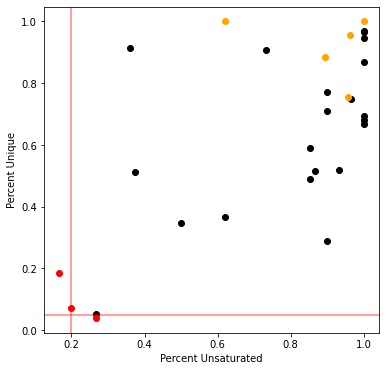

In [24]:
NUM_CELLS_THRESH = 100
PERCENT_UNIQUE_THRESH = 0.05
PERCENT_UNSATURATED_TARGETS_THRESH = 0.2

NT_primary_tumors = tumor_clone_statistics[tumor_clone_statistics.apply(lambda x: 'NT' in x.name and x.name.split("_")[2].startswith("T"), axis=1)].index

NT_clone_statistics = tumor_clone_statistics.loc[NT_primary_tumors]

low_qc = NT_clone_statistics[(NT_clone_statistics['PercentUnique'] <=PERCENT_UNIQUE_THRESH) |
                                 (NT_clone_statistics['PercentUnsaturatedTargets'] <= PERCENT_UNSATURATED_TARGETS_THRESH)].index
small = NT_clone_statistics[(NT_clone_statistics['NumCells'] < NUM_CELLS_THRESH)].index

unfiltered = np.setdiff1d(NT_primary_tumors, np.union1d(low_qc, small))

h = plt.figure(figsize=(6,6))
plt.scatter(NT_clone_statistics.loc[unfiltered, 'PercentUnsaturatedTargets'], NT_clone_statistics.loc[unfiltered, 'PercentUnique'], color='black')
plt.scatter(NT_clone_statistics.loc[low_qc, 'PercentUnsaturatedTargets'], NT_clone_statistics.loc[low_qc, 'PercentUnique'], color='red')
plt.scatter(NT_clone_statistics.loc[small, 'PercentUnsaturatedTargets'], NT_clone_statistics.loc[small, 'PercentUnique'], color='orange')


plt.axhline(y = PERCENT_UNIQUE_THRESH, color='red', alpha=0.5)
plt.axvline(x = PERCENT_UNSATURATED_TARGETS_THRESH, color='red', alpha=0.5)
plt.xlabel("Percent Unsaturated")
plt.ylabel("Percent Unique")